# Imports et configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Configuration matplotlib pour les graphes
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# 1. Définition des fonctions de test

In [2]:
def quadratique(x):
    """f(x, y) = x² + 2y²"""
    return x[0]**2 + 2*x[1]**2

def grad_quadratique(x):
    """Gradient analytique de la fonction quadratique"""
    return np.array([2*x[0], 4*x[1]])


def rosenbrock(x):
    """f(x, y) = (1-x)² + 100(y-x²)²
    Minimum global : (1, 1) avec f(1,1) = 0
    """
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

def grad_rosenbrock(x):
    """Gradient analytique de Rosenbrock"""
    gx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    gy = 200*(x[1] - x[0]**2)
    return np.array([gx, gy])


def booth(x):
    """f(x, y) = (x + 2y - 7)² + (2x + y - 5)²
    Minimum global : (1, 3) avec f(1,3) = 0
    """
    return (x[0] + 2*x[1] - 7)**2 + (2*x[0] + x[1] - 5)**2

def grad_booth(x):
    """Gradient analytique de Booth"""
    gx = 2*(x[0] + 2*x[1] - 7) + 4*(2*x[0] + x[1] - 5)
    gy = 4*(x[0] + 2*x[1] - 7) + 2*(2*x[0] + x[1] - 5)
    return np.array([gx, gy])


def beale(x):
    """f(x, y) = (1.5 - x + xy)² + (2.25 - x + xy²)² + (2.625 - x + xy³)²
    Minimum global : (3, 0.5) avec f(3,0.5) = 0
    """
    term1 = (1.5 - x[0] + x[0]*x[1])**2
    term2 = (2.25 - x[0] + x[0]*x[1]**2)**2
    term3 = (2.625 - x[0] + x[0]*x[1]**3)**2
    return term1 + term2 + term3

def grad_beale(x):
    """Gradient numérique de Beale"""
    h = 1e-5
    gx = (beale(x + np.array([h, 0])) - beale(x - np.array([h, 0]))) / (2*h)
    gy = (beale(x + np.array([0, h])) - beale(x - np.array([0, h]))) / (2*h)
    return np.array([gx, gy])


def himmelblau(x):
    """f(x, y) = (x² + y - 11)² + (x + y² - 7)²
    4 minima globaux : (3, 2), (-2.805, 3.131), (-3.779, -3.283), (3.584, -1.848)
    Tous avec f = 0
    """
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def grad_himmelblau(x):
    """Gradient analytique de Himmelblau"""
    gx = 4*x[0]*(x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)
    gy = 2*(x[0]**2 + x[1] - 11) + 4*x[1]*(x[0] + x[1]**2 - 7)
    return np.array([gx, gy])

# 2. Algorithmes d'optimisation

In [3]:
def gradient_descent(f, grad_f, x0, learning_rate=0.01, max_iter=1000, tol=1e-6):
    """
    Descente de gradient simple.
    
    Formule : x_new = x - learning_rate × ∇f(x)
    """
    x = x0.copy()
    trajectory = [x.copy()]
    costs = [f(x)]
    
    for i in range(max_iter):
        grad = grad_f(x)

        # DEBUG : Afficher la norme du gradient
        grad_norm = np.linalg.norm(grad)
        if i < 5 or i % 100 == 0:  # Afficher les premières itérations
            print(f"  Iter {i}: grad_norm = {grad_norm:.2e}, cost = {costs[-1]:.6f}")
        
        # Critère d'arrêt : gradient très petit et coût très petit
        if np.linalg.norm(grad) < tol:
            break
        
        # Mise à jour
        x = x - learning_rate * grad
        trajectory.append(x.copy())
        costs.append(f(x))
    
    return np.array(trajectory), np.array(costs)


def gradient_descent_momentum(f, grad_f, x0, learning_rate=0.01, momentum=0.8, 
                               max_iter=1000, tol=1e-6):    
    """
    Descente de gradient avec Momentum.
    
    Formule : 
        v = momentum × v + learning_rate × ∇f(x)
        x_new = x - v
    """
    x = x0.copy()
    v = np.zeros_like(x)
    trajectory = [x.copy()]
    costs = [f(x)]
    
    for i in range(max_iter):
        grad = grad_f(x)
        
        if np.linalg.norm(grad) < tol:
            break
        
        # Mise à jour de la vitesse
        v = momentum * v + learning_rate * grad
        
        # Mise à jour de la position
        x = x - v
        trajectory.append(x.copy())
        costs.append(f(x))
    
    return np.array(trajectory), np.array(costs)


def gradient_descent_nesterov(f, grad_f, x0, learning_rate=0.01, momentum=0.8,
                               max_iter=1000, tol=1e-6):
    """
    Descente de gradient Nesterov (NAG).
    
    Formule :
        x_lookahead = x - momentum × v
        v = momentum × v + learning_rate × ∇f(x_lookahead)
        x_new = x - v
    """
    x = x0.copy()
    v = np.zeros_like(x)
    trajectory = [x.copy()]
    costs = [f(x)]
    
    for i in range(max_iter):
        # Point anticipé
        x_lookahead = x - momentum * v
        grad = grad_f(x_lookahead)
        
        if np.linalg.norm(grad) < tol:
            break
        
        # Mise à jour de la vitesse
        v = momentum * v + learning_rate * grad
        
        # Mise à jour de la position
        x = x - v
        trajectory.append(x.copy())
        costs.append(f(x))
    
    return np.array(trajectory), np.array(costs)


def gradient_descent_adam(f, grad_f, x0, learning_rate=0.01, beta1=0.9, beta2=0.999,
                          epsilon=1e-8, max_iter=1000, tol=1e-6):
    """
    Algorithme Adam (Adaptive Moment Estimation).
    
    Formule :
        m = beta1 × m + (1-beta1) × ∇f(x)
        v = beta2 × v + (1-beta2) × (∇f(x))²
        m_hat = m / (1 - beta1^t)
        v_hat = v / (1 - beta2^t)
        x_new = x - learning_rate × m_hat / (√v_hat + epsilon)
    """
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    trajectory = [x.copy()]
    costs = [f(x)]
    
    for t in range(1, max_iter + 1):
        grad = grad_f(x)
        
        if np.linalg.norm(grad) < tol:
            break
        
        # Mise à jour des moments
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        
        # Correction du biais
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        
        # Mise à jour de la position
        x = x - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        trajectory.append(x.copy())
        costs.append(f(x))
    
    return np.array(trajectory), np.array(costs)

# 3. Fonctions de visualisation

In [4]:
def plot_trajectory_2d(f, trajectory, costs, x_range, y_range, 
                       title="", algo_name="", num_levels=30, figsize=(10, 8)):
    """
    Graphe professionnel avec courbes de niveau et trajectoire.
    Style épuré et clean.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Grille pour les courbes de niveau
    x = np.linspace(x_range[0], x_range[1], 200)
    y = np.linspace(y_range[0], y_range[1], 200)
    X, Y = np.meshgrid(x, y)
    
    # Calcul de Z
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))
    
    # Courbes de niveau avec dégradé
    ax.contour(X, Y, Z, levels=num_levels, cmap='viridis', linewidths=0.6, alpha=0.8)
    ax.contourf(X, Y, Z, levels=num_levels, cmap='viridis', alpha=0.25)
    
    # Sous-échantillonner si trop long
    if len(trajectory) > 300:
        indices = np.linspace(0, len(trajectory)-1, 300, dtype=int)
        display_traj = trajectory[indices]
    else:
        display_traj = trajectory
    
    # Trajectoire - couleur douce
    ax.plot(display_traj[:, 0], display_traj[:, 1], '-', color='#E07A5F', 
            linewidth=1.8, label=f'{algo_name} ({len(trajectory)} itér.)', alpha=0.85)
    
    # Points discrets : départ et arrivée (petits, sans contour)
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'o', color='#457B9D', 
            markersize=5, label='Départ', zorder=5)
    ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'o', color='#E63946', 
            markersize=5, label='Arrivée', zorder=5)
    
    # Mise en forme épurée
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='medium')
    ax.legend(fontsize=9, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    return fig, ax


def plot_comparison_trajectories(f, trajectories_dict, x_range, y_range,
                                 title="", num_levels=30, figsize=(12, 9)):
    """
    Compare plusieurs algorithmes sur le même graphe.
    Style épuré avec couleurs pastel.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Grille et courbes de niveau
    x = np.linspace(x_range[0], x_range[1], 200)
    y = np.linspace(y_range[0], y_range[1], 200)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f(np.array([X[i, j], Y[i, j]]))
    
    # Courbes de niveau
    ax.contour(X, Y, Z, levels=num_levels, cmap='viridis', linewidths=0.6, alpha=0.8)
    ax.contourf(X, Y, Z, levels=num_levels, cmap='viridis', alpha=0.2)
    
    # Couleurs pastel professionnelles
    colors = ['#E07A5F', '#457B9D', '#6A994E', '#E9A319']  # Terracotta, Steel Blue, Fern, Marigold
    
    for idx, (algo_name, trajectory) in enumerate(trajectories_dict.items()):
        color = colors[idx % len(colors)]
        
        # Sous-échantillonner les longues trajectoires
        if len(trajectory) > 300:
            indices = np.linspace(0, len(trajectory)-1, 300, dtype=int)
            display_traj = trajectory[indices]
        else:
            display_traj = trajectory
        
        # Trajectoire
        ax.plot(display_traj[:, 0], display_traj[:, 1], '-', color=color, 
                linewidth=1.8, label=f'{algo_name} ({len(trajectory)} itér.)', alpha=0.85)
        
        # Points discrets : départ (rond) et arrivée (carré) - petits, sans contour
        ax.plot(trajectory[0, 0], trajectory[0, 1], 'o', color=color, 
                markersize=4, zorder=5)
        ax.plot(trajectory[-1, 0], trajectory[-1, 1], 's', color=color, 
                markersize=4, zorder=5)
    
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('y', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='medium')
    ax.legend(fontsize=9, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    return fig, ax


def plot_convergence_curves(costs_dict, title="Convergence", figsize=(10, 6)):
    """
    Graphe de convergence avec style épuré.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Couleurs pastel
    colors = ['#E07A5F', '#457B9D', '#6A994E', '#E9A319']
    
    for idx, (algo_name, algo_costs) in enumerate(costs_dict.items()):
        costs_array = np.array(algo_costs)
        
        # Gérer les valeurs <= 0 pour l'échelle log
        if np.any(costs_array > 0):
            min_positive = np.min(costs_array[costs_array > 0])
            valid_costs = np.maximum(costs_array, min_positive * 1e-3)
        else:
            valid_costs = np.abs(costs_array) + 1e-12
        
        iterations = range(len(valid_costs))
        ax.plot(iterations, valid_costs, '-', color=colors[idx % len(colors)],
                linewidth=1.8, label=f'{algo_name} ({len(algo_costs)} itér.)', alpha=0.85)
    
    ax.set_xlabel('Itération', fontsize=11)
    ax.set_ylabel('Coût f(x, y)', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='medium')
    ax.legend(fontsize=9, framealpha=0.9)
    ax.grid(True, alpha=0.2, linestyle='-', linewidth=0.5)
    ax.set_yscale('log')
    
    plt.tight_layout()
    return fig, ax

# 4. Expériences

## 4.1 Fonction quatratique

EXPÉRIENCE 1 : Fonction Quadratique f(x,y) = x² + 2y²
  Iter 0: grad_norm = 2.24e+01, cost = 75.000000
  Iter 1: grad_norm = 1.44e+01, cost = 34.000000
  Iter 2: grad_norm = 9.63e+00, cost = 16.720000
  Iter 3: grad_norm = 6.70e+00, cost = 8.886400
  Iter 4: grad_norm = 4.85e+00, cost = 5.034112

Simple : 74 itérations, f(x*) = 0.0000000000
Momentum : 148 itérations, f(x*) = 0.0000000000
Nesterov : 67 itérations, f(x*) = 0.0000000000
Adam : 241 itérations, f(x*) = 0.0000000000


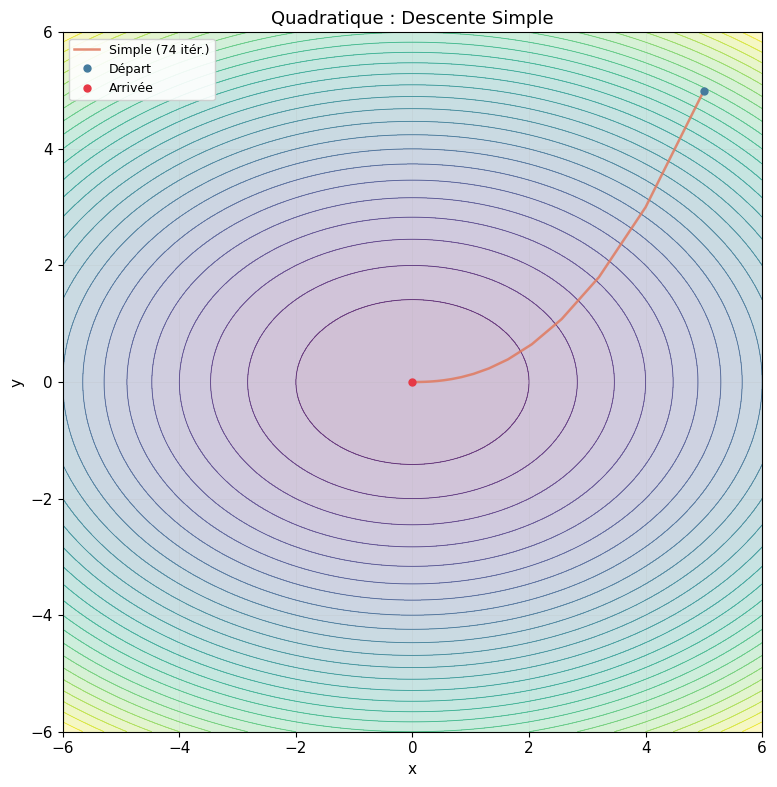

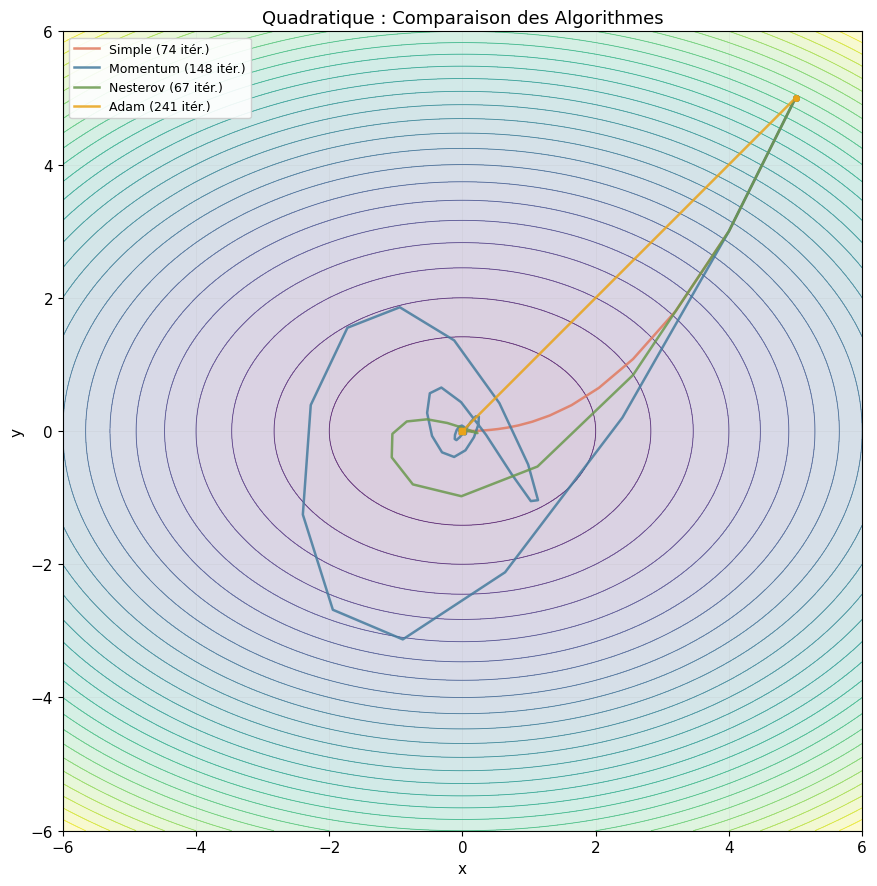

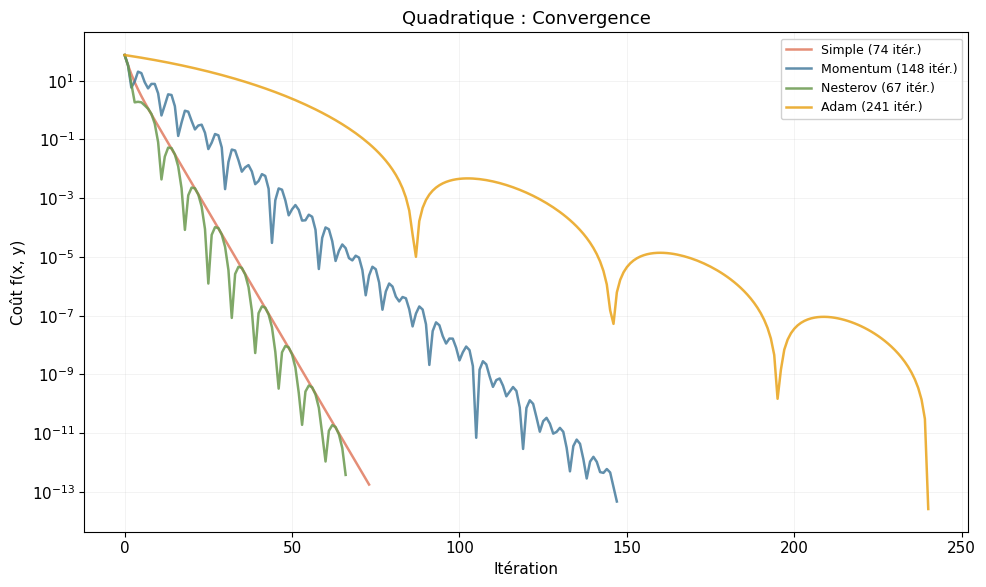

In [5]:
print("="*70)
print("EXPÉRIENCE 1 : Fonction Quadratique f(x,y) = x² + 2y²")
print("="*70)

# Point de départ
x0 = np.array([5.0, 5.0])

# Exécution des algorithmes
traj_simple, costs_simple = gradient_descent(
    quadratique, grad_quadratique, x0, learning_rate=0.1
)

traj_momentum, costs_momentum = gradient_descent_momentum(
    quadratique, grad_quadratique, x0, learning_rate=0.1, momentum=0.8
)

traj_nesterov, costs_nesterov = gradient_descent_nesterov(
    quadratique, grad_quadratique, x0, learning_rate=0.1, momentum=0.8
)

traj_adam, costs_adam = gradient_descent_adam(
    quadratique, grad_quadratique, x0, learning_rate=0.1
)

# Affichage des résultats
print(f"\nSimple : {len(traj_simple)} itérations, f(x*) = {costs_simple[-1]:.10f}")
print(f"Momentum : {len(traj_momentum)} itérations, f(x*) = {costs_momentum[-1]:.10f}")
print(f"Nesterov : {len(traj_nesterov)} itérations, f(x*) = {costs_nesterov[-1]:.10f}")
print(f"Adam : {len(traj_adam)} itérations, f(x*) = {costs_adam[-1]:.10f}")

# Graphe individuel : Simple
fig1, _ = plot_trajectory_2d(
    quadratique, traj_simple, costs_simple,
    x_range=(-6, 6), y_range=(-6, 6),
    title="Quadratique : Descente Simple",
    algo_name="Simple"
)
plt.savefig('../figures/temp/quad_simple.png', dpi=300, bbox_inches='tight')
plt.show()


# Graphe de comparaison
trajectories = {
    'Simple': traj_simple,
    'Momentum': traj_momentum,
    'Nesterov': traj_nesterov,
    'Adam': traj_adam
}

fig2, _ = plot_comparison_trajectories(
    quadratique, trajectories,
    x_range=(-6, 6), y_range=(-6, 6),
    title="Quadratique : Comparaison des Algorithmes"
)
plt.savefig('../figures/temp/quad_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Courbes de convergence
costs = {
    'Simple': costs_simple,
    'Momentum': costs_momentum,
    'Nesterov': costs_nesterov,
    'Adam': costs_adam
}

fig3, _ = plot_convergence_curves(
    costs, title="Quadratique : Convergence"
)
plt.savefig('../figures/temp/quad_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 4.2 Fonctions Simples g et h

EXPÉRIENCE 4.2 : Fonctions Simples g(x,y) et h(x,y)

--- Fonction g : 1 - exp(-10x² - y²) ---
  Iter 0: grad_norm = 2.24e+00, cost = 0.628423
  Iter 1: grad_norm = 2.50e+00, cost = 0.467122
  Iter 2: grad_norm = 2.31e+00, cost = 0.282587
  Iter 3: grad_norm = 1.61e+00, cost = 0.143933
  Iter 4: grad_norm = 9.35e-01, cost = 0.082163
  Iter 100: grad_norm = 1.41e-03, cost = 0.000000
  Iter 200: grad_norm = 2.90e-06, cost = 0.000000

Simple : 219 itérations, f(x*) = 0.0000000000
Momentum : 90 itérations, f(x*) = 0.0000000000
Nesterov : 99 itérations, f(x*) = 0.0000000000
Adam : 206 itérations, f(x*) = 0.0000000000


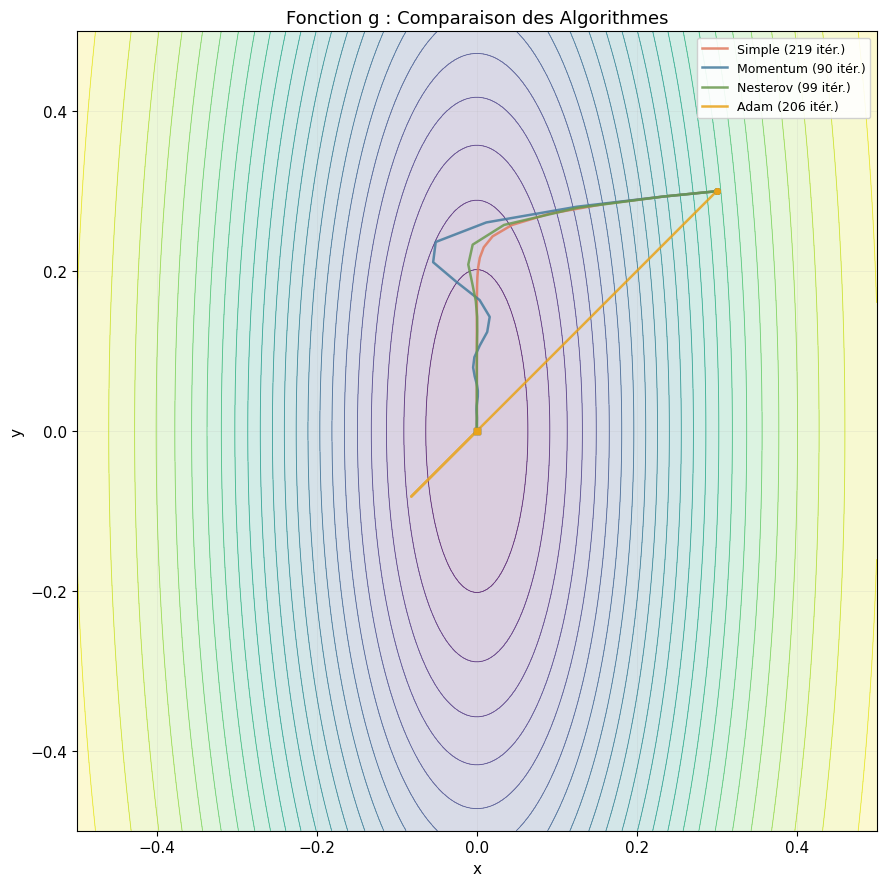

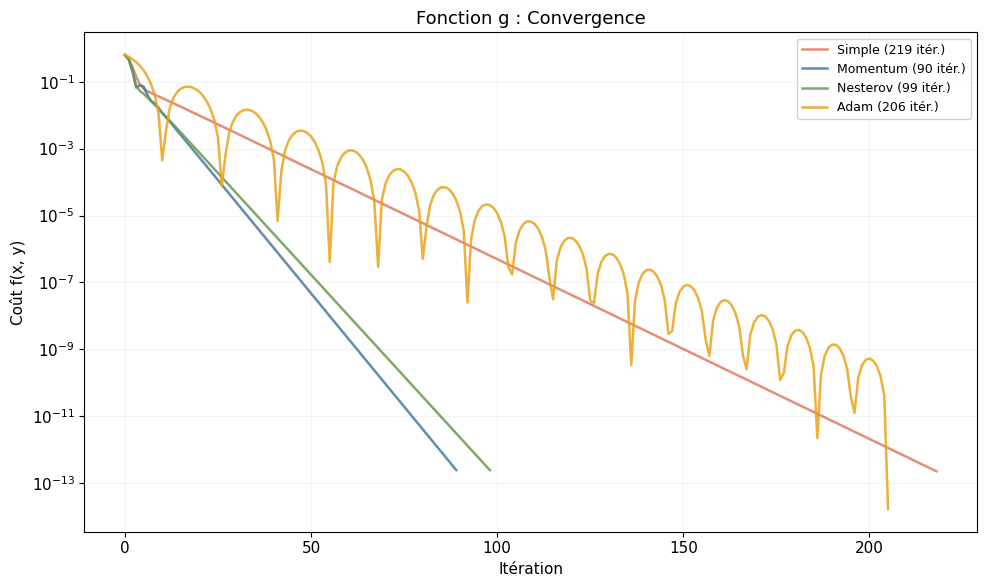


--- Fonction h : x²y - 2xy³ + 3xy + 4 ---
  Iter 0: grad_norm = 2.02e+00, cost = 4.750000
  Iter 1: grad_norm = 1.97e+00, cost = 4.709819
  Iter 2: grad_norm = 1.93e+00, cost = 4.671388
  Iter 3: grad_norm = 1.88e+00, cost = 4.634662
  Iter 4: grad_norm = 1.84e+00, cost = 4.599595
  Iter 100: grad_norm = 9.50e-01, cost = 3.558115
  Iter 200: grad_norm = 2.63e-01, cost = 3.246605
  Iter 300: grad_norm = 9.87e-02, cost = 3.216543
  Iter 400: grad_norm = 3.90e-02, cost = 3.212120

Simple : 501 itérations, f(x*) = 3.2114176125
Point final : (-1.1827, 0.5507)

Momentum : 244 itérations, f(x*) = 3.2112795172
Point final : (-1.2000, 0.5477)

Nesterov : 259 itérations, f(x*) = 3.2112795172
Point final : (-1.2000, 0.5477)

Adam : 501 itérations, f(x*) = 4.0359555706
Point final : (0.1606, 0.0711)


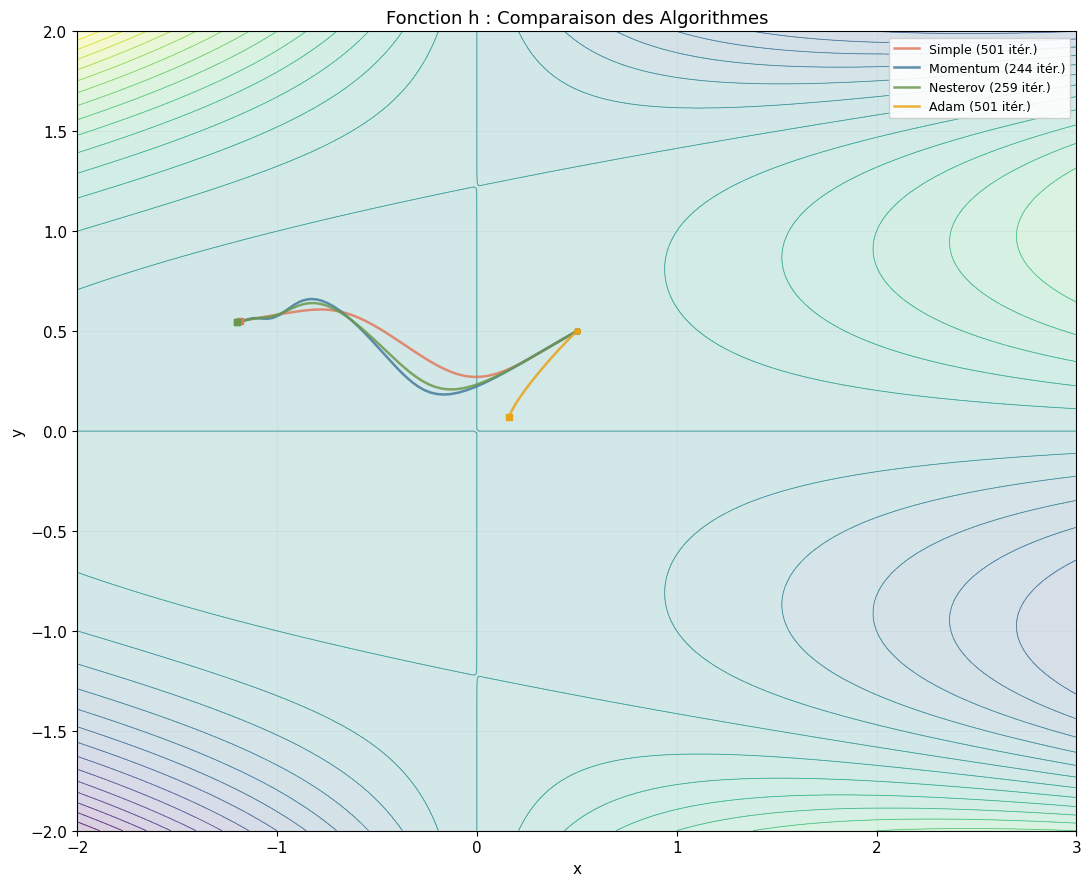

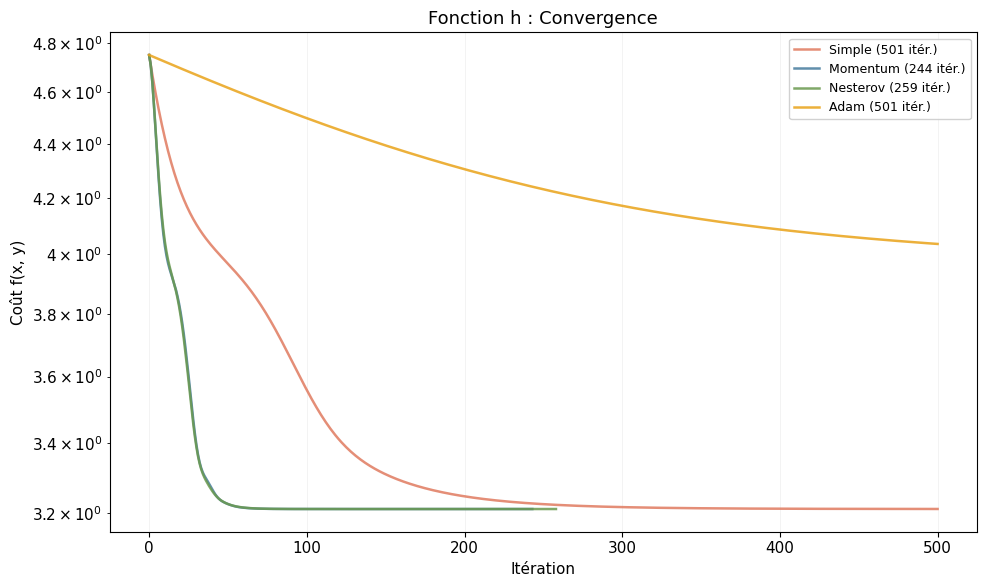

In [6]:
print("="*70)
print("EXPÉRIENCE 4.2 : Fonctions Simples g(x,y) et h(x,y)")
print("="*70)

# Définir les fonctions
def g(x):
    """g(x,y) = 1 - exp(-10x² - y²)"""
    return 1 - np.exp(-10*x[0]**2 - x[1]**2)

def grad_g(x):
    """Gradient de g"""
    exp_term = np.exp(-10*x[0]**2 - x[1]**2)
    gx = 20*x[0] * exp_term
    gy = 2*x[1] * exp_term
    return np.array([gx, gy])

def h(x):
    """h(x,y) = x²y - 2xy³ + 3xy + 4"""
    return x[0]**2 * x[1] - 2*x[0]*x[1]**3 + 3*x[0]*x[1] + 4

def grad_h(x):
    """Gradient de h"""
    gx = 2*x[0]*x[1] - 2*x[1]**3 + 3*x[1]
    gy = x[0]**2 - 6*x[0]*x[1]**2 + 3*x[0]
    return np.array([gx, gy])


# =========================================================================
# TEST 1 : Fonction g (plateau)
# =========================================================================

print("\n--- Fonction g : 1 - exp(-10x² - y²) ---")
x0 = np.array([0.3, 0.3])  # Point où le gradient est significatif

traj_simple_g, costs_simple_g = gradient_descent(
    g, grad_g, x0, learning_rate=0.03, max_iter=500, tol=1e-6  # ← 0.03 pour trajectoires lisses
)

traj_momentum_g, costs_momentum_g = gradient_descent_momentum(
    g, grad_g, x0, learning_rate=0.03, momentum=0.5, max_iter=500, tol=1e-6  # ← trajectoires lisses
)

traj_nesterov_g, costs_nesterov_g = gradient_descent_nesterov(
    g, grad_g, x0, learning_rate=0.03, momentum=0.5, max_iter=500, tol=1e-6  # ← trajectoires lisses
)

traj_adam_g, costs_adam_g = gradient_descent_adam(
    g, grad_g, x0, learning_rate=0.03, max_iter=500, tol=1e-6  # ← 0.03 pour trajectoires lisses
)

print(f"\nSimple : {len(traj_simple_g)} itérations, f(x*) = {costs_simple_g[-1]:.10f}")
print(f"Momentum : {len(traj_momentum_g)} itérations, f(x*) = {costs_momentum_g[-1]:.10f}")
print(f"Nesterov : {len(traj_nesterov_g)} itérations, f(x*) = {costs_nesterov_g[-1]:.10f}")
print(f"Adam : {len(traj_adam_g)} itérations, f(x*) = {costs_adam_g[-1]:.10f}")

# Graphe de comparaison pour g
trajectories_g = {
    'Simple': traj_simple_g,
    'Momentum': traj_momentum_g,
    'Nesterov': traj_nesterov_g,
    'Adam': traj_adam_g
}

fig, _ = plot_comparison_trajectories(
    g, trajectories_g,
    x_range=(-0.5, 0.5), y_range=(-0.5, 0.5),
    title="Fonction g : Comparaison des Algorithmes"
)
plt.savefig('../figures/temp/g_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Courbes de convergence pour g
costs_g = {
    'Simple': costs_simple_g,
    'Momentum': costs_momentum_g,
    'Nesterov': costs_nesterov_g,
    'Adam': costs_adam_g
}

fig, _ = plot_convergence_curves(
    costs_g, title="Fonction g : Convergence"
)
plt.savefig('../figures/temp/g_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



# =========================================================================
# TEST 2 : Fonction h (polynôme complexe)
# =========================================================================

print("\n--- Fonction h : x²y - 2xy³ + 3xy + 4 ---")
x0 = np.array([0.5, 0.5])  # Point de départ quelconque
                            # MODIF : point plus proche -> 0.5 au lieu de 2.0, 1.0

traj_simple_h, costs_simple_h = gradient_descent(
    h, grad_h, x0, learning_rate=0.01, max_iter=500, tol=1e-6  # ← 0.01 au lieu de 0.0005
)

traj_momentum_h, costs_momentum_h = gradient_descent_momentum(
    h, grad_h, x0, learning_rate=0.01, momentum=0.8, max_iter=500, tol=1e-6  # ← 0.01 et 0.8
)

traj_nesterov_h, costs_nesterov_h = gradient_descent_nesterov(
    h, grad_h, x0, learning_rate=0.01, momentum=0.8, max_iter=500, tol=1e-6  # ← 0.01 et 0.8
)

traj_adam_h, costs_adam_h = gradient_descent_adam(
    h, grad_h, x0, learning_rate=0.001, max_iter=500, tol=1e-6  # ← 0.001 pour éviter divergence
)

print(f"\nSimple : {len(traj_simple_h)} itérations, f(x*) = {costs_simple_h[-1]:.10f}")
print(f"Point final : ({traj_simple_h[-1][0]:.4f}, {traj_simple_h[-1][1]:.4f})")

print(f"\nMomentum : {len(traj_momentum_h)} itérations, f(x*) = {costs_momentum_h[-1]:.10f}")
print(f"Point final : ({traj_momentum_h[-1][0]:.4f}, {traj_momentum_h[-1][1]:.4f})")

print(f"\nNesterov : {len(traj_nesterov_h)} itérations, f(x*) = {costs_nesterov_h[-1]:.10f}")
print(f"Point final : ({traj_nesterov_h[-1][0]:.4f}, {traj_nesterov_h[-1][1]:.4f})")

print(f"\nAdam : {len(traj_adam_h)} itérations, f(x*) = {costs_adam_h[-1]:.10f}")
print(f"Point final : ({traj_adam_h[-1][0]:.4f}, {traj_adam_h[-1][1]:.4f})")

# Graphe de comparaison pour h
trajectories_h = {
    'Simple': traj_simple_h,
    'Momentum': traj_momentum_h,
    'Nesterov': traj_nesterov_h,
    'Adam': traj_adam_h
}

fig, _ = plot_comparison_trajectories(
    h, trajectories_h,
    x_range=(-2, 3), y_range=(-2, 2),
    title="Fonction h : Comparaison des Algorithmes"
)
plt.savefig('../figures/temp/h_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Courbes de convergence pour h
costs_h = {
    'Simple': costs_simple_h,
    'Momentum': costs_momentum_h,
    'Nesterov': costs_nesterov_h,
    'Adam': costs_adam_h
}

fig, _ = plot_convergence_curves(
    costs_h, title="Fonction h : Convergence"
)
plt.savefig('../figures/temp/h_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 4.3 Fonction de Rosenbrock


EXPÉRIENCE 3 : Fonction de Rosenbrock
  Iter 0: grad_norm = 4.00e+00, cost = 4.000000
  Iter 1: grad_norm = 1.79e+00, cost = 3.990390
  Iter 2: grad_norm = 1.79e+00, cost = 3.987182
  Iter 3: grad_norm = 1.79e+00, cost = 3.983973
  Iter 4: grad_norm = 1.79e+00, cost = 3.980761
  Iter 100: grad_norm = 1.84e+00, cost = 3.664727
  Iter 200: grad_norm = 1.90e+00, cost = 3.316663
  Iter 300: grad_norm = 1.97e+00, cost = 2.944357
  Iter 400: grad_norm = 2.05e+00, cost = 2.540836
  Iter 500: grad_norm = 2.16e+00, cost = 2.097570
  Iter 600: grad_norm = 2.24e+00, cost = 1.612178
  Iter 700: grad_norm = 2.11e+00, cost = 1.128004
  Iter 800: grad_norm = 1.69e+00, cost = 0.760890
  Iter 900: grad_norm = 1.30e+00, cost = 0.539684
  Iter 1000: grad_norm = 1.03e+00, cost = 0.405875
  Iter 1100: grad_norm = 8.49e-01, cost = 0.318344
  Iter 1200: grad_norm = 7.21e-01, cost = 0.257073
  Iter 1300: grad_norm = 6.25e-01, cost = 0.211994
  Iter 1400: grad_norm = 5.50e-01, cost = 0.177587
  Iter 1500: gra

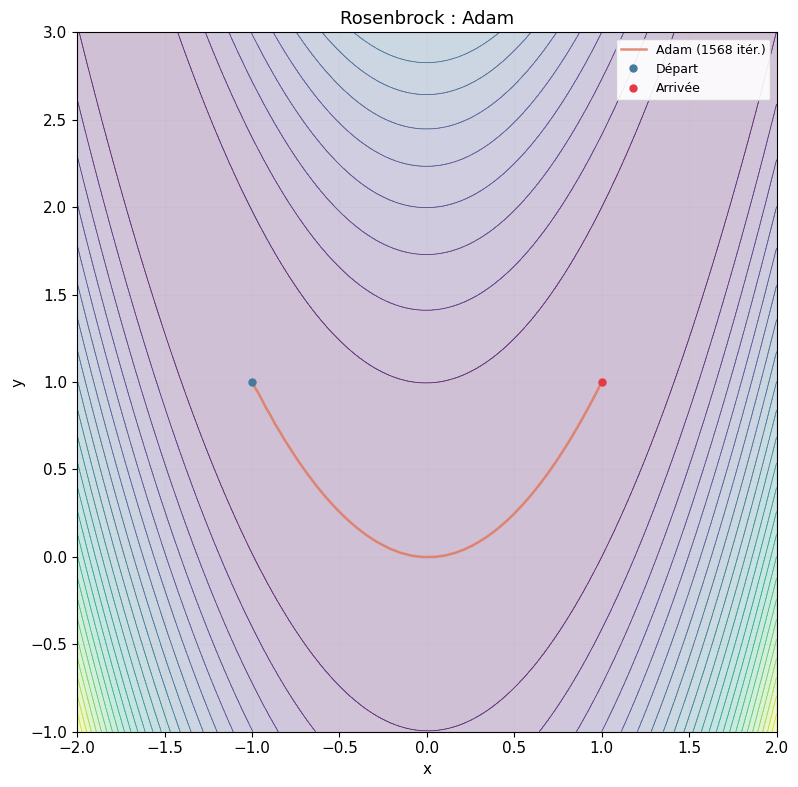

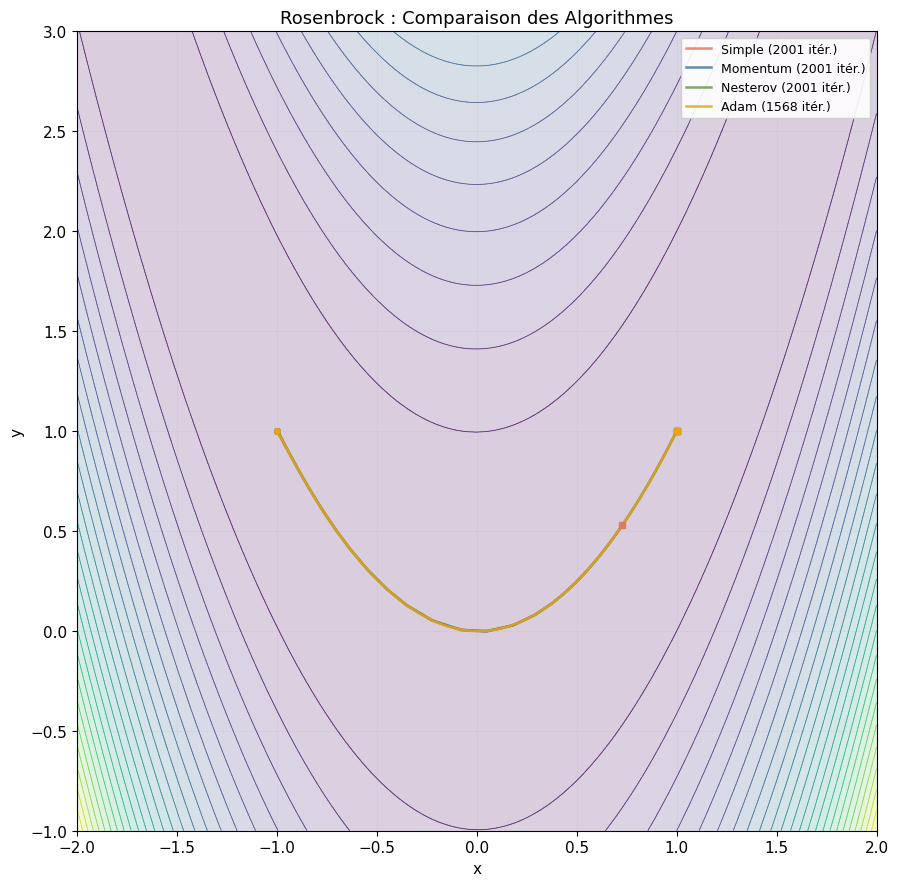

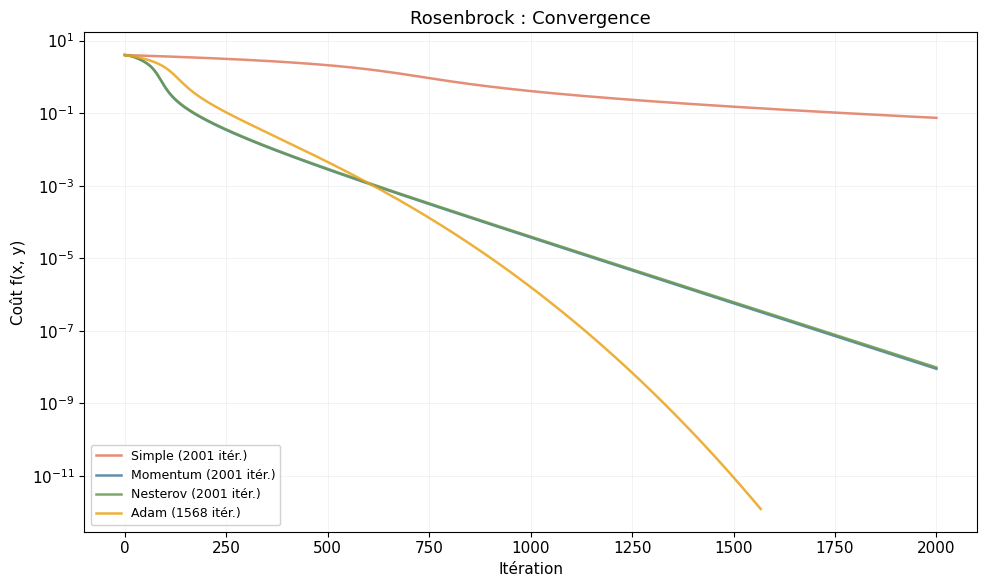

In [7]:
print("\n" + "="*70)
print("EXPÉRIENCE 3 : Fonction de Rosenbrock")
print("="*70)

# Point de départ
x0 = np.array([-1.0, 1.0])

# Exécution des algorithmes
traj_simple, costs_simple = gradient_descent(
    rosenbrock, grad_rosenbrock, x0, learning_rate=0.001, max_iter=2000
)

traj_momentum, costs_momentum = gradient_descent_momentum(
    rosenbrock, grad_rosenbrock, x0, learning_rate=0.001, momentum=0.9, max_iter=2000
)

traj_nesterov, costs_nesterov = gradient_descent_nesterov(
    rosenbrock, grad_rosenbrock, x0, learning_rate=0.001, momentum=0.9, max_iter=2000
)

traj_adam, costs_adam = gradient_descent_adam(
    rosenbrock, grad_rosenbrock, x0, learning_rate=0.01, max_iter=2000
)

# Affichage des résultats
print(f"\nSimple : {len(traj_simple)} itérations, f(x*) = {costs_simple[-1]:.10f}")
print(f"Momentum : {len(traj_momentum)} itérations, f(x*) = {costs_momentum[-1]:.10f}")
print(f"Nesterov : {len(traj_nesterov)} itérations, f(x*) = {costs_nesterov[-1]:.10f}")
print(f"Adam : {len(traj_adam)} itérations, f(x*) = {costs_adam[-1]:.10f}")

# Graphe individuel : Adam (le plus performant)
fig1, _ = plot_trajectory_2d(
    rosenbrock, traj_adam, costs_adam,
    x_range=(-2, 2), y_range=(-1, 3),
    title="Rosenbrock : Adam",
    algo_name="Adam"
)
plt.savefig('../figures/temp/rosenbrock_adam.png', dpi=300, bbox_inches='tight')
plt.show()


# Graphe de comparaison
trajectories = {
    'Simple': traj_simple,
    'Momentum': traj_momentum,
    'Nesterov': traj_nesterov,
    'Adam': traj_adam
}

fig2, _ = plot_comparison_trajectories(
    rosenbrock, trajectories,
    x_range=(-2, 2), y_range=(-1, 3),
    title="Rosenbrock : Comparaison des Algorithmes"
)
plt.savefig('../figures/temp/rosenbrock_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Courbes de convergence
costs = {
    'Simple': costs_simple,
    'Momentum': costs_momentum,
    'Nesterov': costs_nesterov,
    'Adam': costs_adam
}

fig3, _ = plot_convergence_curves(
    costs, title="Rosenbrock : Convergence"
)
plt.savefig('../figures/temp/rosenbrock_convergence.png', dpi=300, bbox_inches='tight')
plt.show()




## 4.4 Fonction de Booth


EXPÉRIENCE 4 : Fonction de Booth
  Iter 0: grad_norm = 5.10e+01, cost = 74.000000
  Iter 1: grad_norm = 4.18e+01, cost = 50.333600
  Iter 2: grad_norm = 3.43e+01, cost = 34.397503
  Iter 3: grad_norm = 2.82e+01, cost = 23.660165
  Iter 4: grad_norm = 2.32e+01, cost = 16.419340
  Iter 100: grad_norm = 3.75e-01, cost = 0.035176
  Iter 200: grad_norm = 4.97e-02, cost = 0.000619
  Iter 300: grad_norm = 6.60e-03, cost = 0.000011
  Iter 400: grad_norm = 8.75e-04, cost = 0.000000
  Iter 500: grad_norm = 1.16e-04, cost = 0.000000
  Iter 600: grad_norm = 1.54e-05, cost = 0.000000
  Iter 700: grad_norm = 2.04e-06, cost = 0.000000

Simple : 737 itérations, f(x*) = 0.0000000000
Momentum : 300 itérations, f(x*) = 0.0000000000
Nesterov : 205 itérations, f(x*) = 0.0000000000
Adam : 346 itérations, f(x*) = 0.0000000000


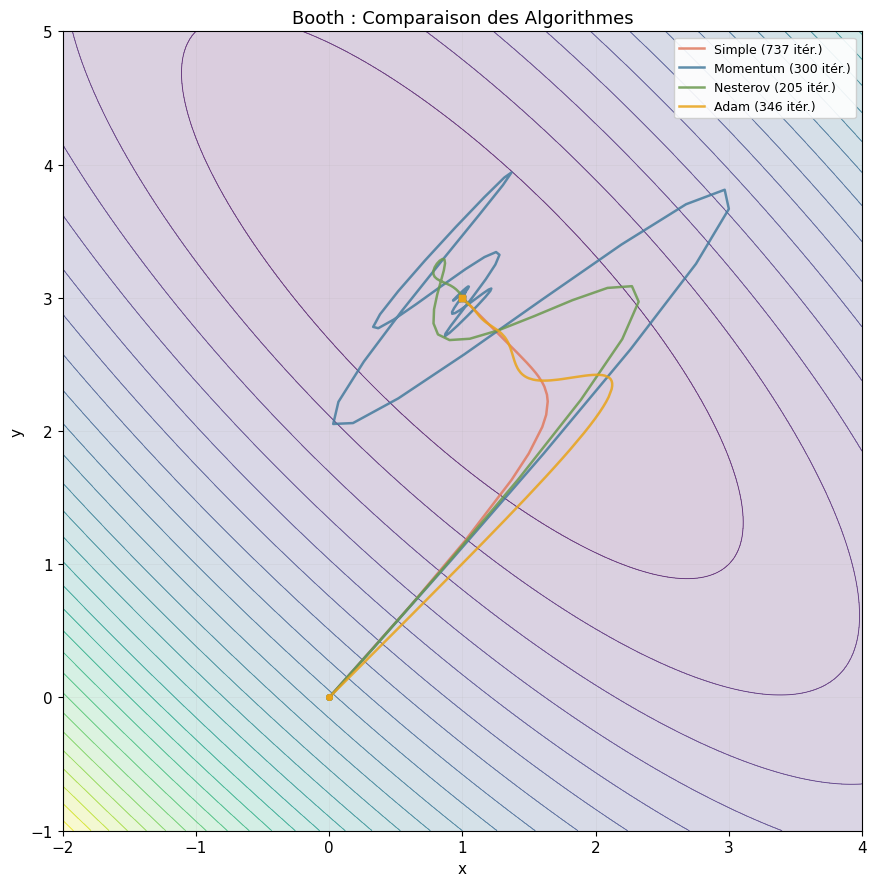

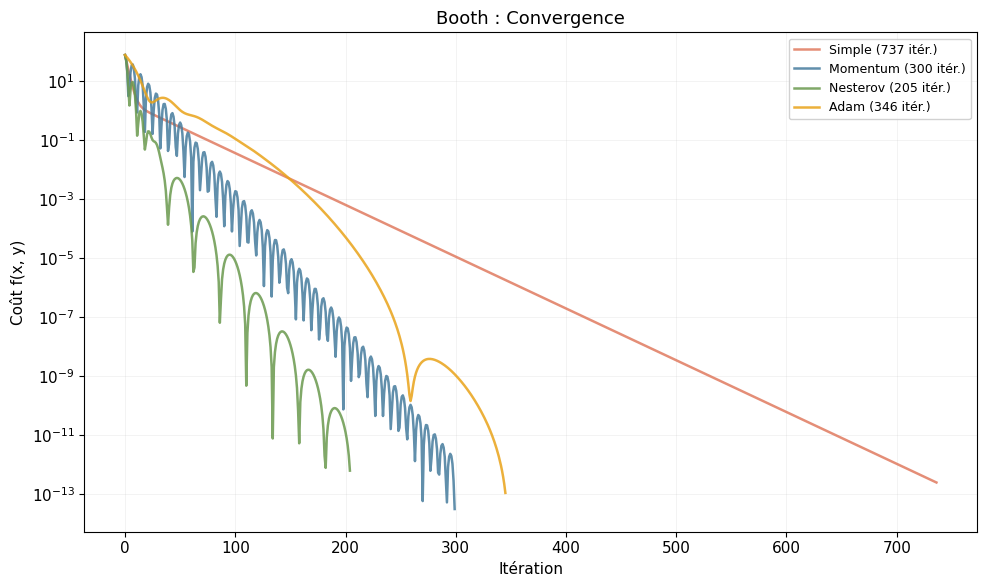

In [8]:
print("\n" + "="*70)
print("EXPÉRIENCE 4 : Fonction de Booth")
print("="*70)

# Point de départ
x0 = np.array([0.0, 0.0])

# Exécution des algorithmes
traj_simple, costs_simple = gradient_descent(
    booth, grad_booth, x0, learning_rate=0.01
)

traj_momentum, costs_momentum = gradient_descent_momentum(
    booth, grad_booth, x0, learning_rate=0.01, momentum=0.9
)

traj_nesterov, costs_nesterov = gradient_descent_nesterov(
    booth, grad_booth, x0, learning_rate=0.01, momentum=0.9
)

traj_adam, costs_adam = gradient_descent_adam(
    booth, grad_booth, x0, learning_rate=0.1
)

# Affichage des résultats
print(f"\nSimple : {len(traj_simple)} itérations, f(x*) = {costs_simple[-1]:.10f}")
print(f"Momentum : {len(traj_momentum)} itérations, f(x*) = {costs_momentum[-1]:.10f}")
print(f"Nesterov : {len(traj_nesterov)} itérations, f(x*) = {costs_nesterov[-1]:.10f}")
print(f"Adam : {len(traj_adam)} itérations, f(x*) = {costs_adam[-1]:.10f}")

# Graphe de comparaison
trajectories = {
    'Simple': traj_simple,
    'Momentum': traj_momentum,
    'Nesterov': traj_nesterov,
    'Adam': traj_adam
}

fig, _ = plot_comparison_trajectories(
    booth, trajectories,
    x_range=(-2, 4), y_range=(-1, 5),
    title="Booth : Comparaison des Algorithmes"
)
plt.savefig('../figures/temp/booth_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Courbes de convergence
costs = {
    'Simple': costs_simple,
    'Momentum': costs_momentum,
    'Nesterov': costs_nesterov,
    'Adam': costs_adam
}

fig, _ = plot_convergence_curves(
    costs, title="Booth : Convergence"
)
plt.savefig('../figures/temp/booth_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 4.5 Fonction de Beale


EXPÉRIENCE 5 : Fonction de Beale
  Iter 0: grad_norm = 1.28e+01, cost = 14.203125
  Iter 1: grad_norm = 1.27e+01, cost = 14.041050
  Iter 2: grad_norm = 1.26e+01, cost = 13.880912
  Iter 3: grad_norm = 1.25e+01, cost = 13.722681
  Iter 4: grad_norm = 1.24e+01, cost = 13.566329
  Iter 100: grad_norm = 6.94e+00, cost = 4.666425
  Iter 200: grad_norm = 3.73e+00, cost = 1.946025
  Iter 300: grad_norm = 2.38e+00, cost = 1.054125
  Iter 400: grad_norm = 1.70e+00, cost = 0.646357
  Iter 500: grad_norm = 1.27e+00, cost = 0.427891
  Iter 600: grad_norm = 9.91e-01, cost = 0.300891
  Iter 700: grad_norm = 7.95e-01, cost = 0.221798
  Iter 800: grad_norm = 6.55e-01, cost = 0.169569
  Iter 900: grad_norm = 5.51e-01, cost = 0.133385
  Iter 1000: grad_norm = 4.72e-01, cost = 0.107323
  Iter 1100: grad_norm = 4.10e-01, cost = 0.087946
  Iter 1200: grad_norm = 3.60e-01, cost = 0.073156
  Iter 1300: grad_norm = 3.20e-01, cost = 0.061617
  Iter 1400: grad_norm = 2.86e-01, cost = 0.052447
  Iter 1500: gra

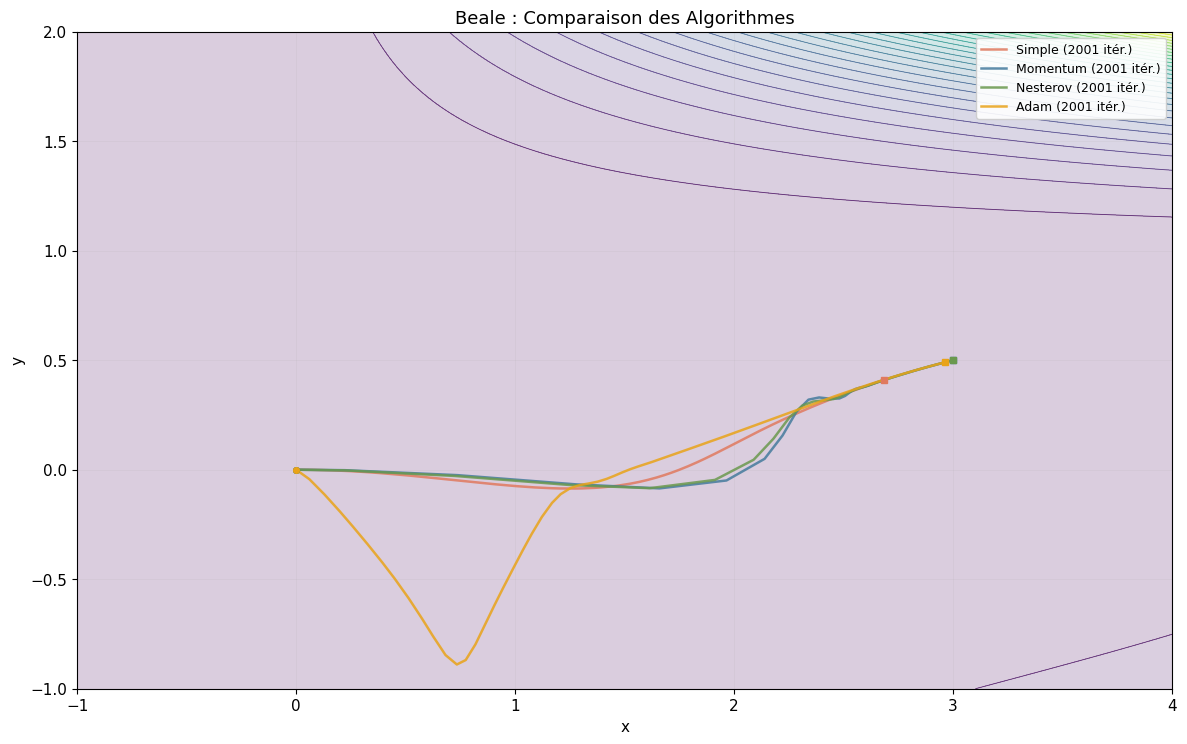

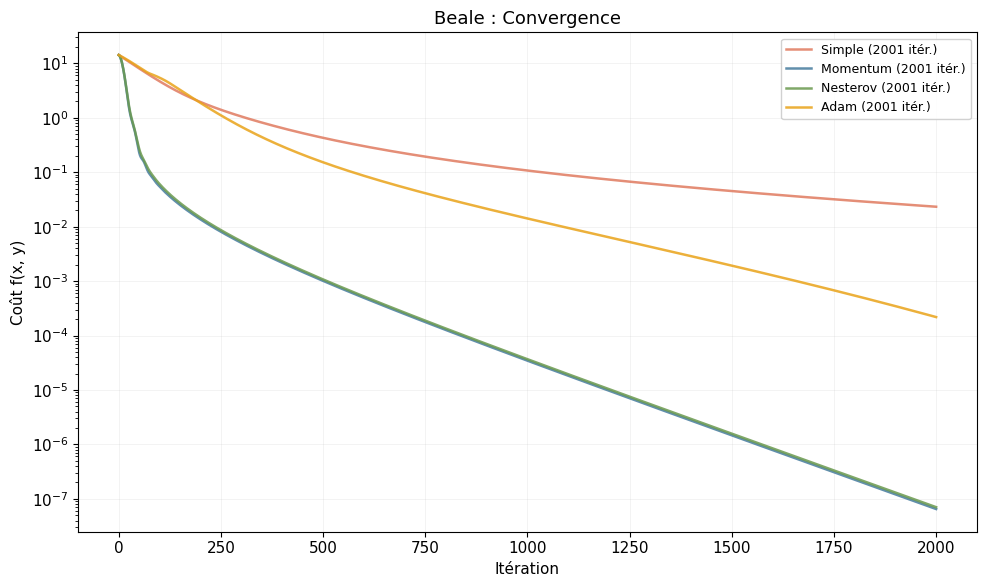

In [9]:
print("\n" + "="*70)
print("EXPÉRIENCE 5 : Fonction de Beale")
print("="*70)

# Point de départ
x0 = np.array([0.0, 0.0])

# Exécution des algorithmes
traj_simple, costs_simple = gradient_descent(
    beale, grad_beale, x0, learning_rate=0.001, max_iter=2000
)

traj_momentum, costs_momentum = gradient_descent_momentum(
    beale, grad_beale, x0, learning_rate=0.001, momentum=0.9, max_iter=2000
)

traj_nesterov, costs_nesterov = gradient_descent_nesterov(
    beale, grad_beale, x0, learning_rate=0.001, momentum=0.9, max_iter=2000
)

traj_adam, costs_adam = gradient_descent_adam(
    beale, grad_beale, x0, learning_rate=0.01, max_iter=2000
)

# Affichage des résultats
print(f"\nSimple : {len(traj_simple)} itérations, f(x*) = {costs_simple[-1]:.10f}")
print(f"Momentum : {len(traj_momentum)} itérations, f(x*) = {costs_momentum[-1]:.10f}")
print(f"Nesterov : {len(traj_nesterov)} itérations, f(x*) = {costs_nesterov[-1]:.10f}")
print(f"Adam : {len(traj_adam)} itérations, f(x*) = {costs_adam[-1]:.10f}")

# Graphe de comparaison
trajectories = {
    'Simple': traj_simple,
    'Momentum': traj_momentum,
    'Nesterov': traj_nesterov,
    'Adam': traj_adam
}

fig, _ = plot_comparison_trajectories(
    beale, trajectories,
    x_range=(-1, 4), y_range=(-1, 2),
    title="Beale : Comparaison des Algorithmes"
)
plt.savefig('../figures/temp/beale_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Courbes de convergence
costs = {
    'Simple': costs_simple,
    'Momentum': costs_momentum,
    'Nesterov': costs_nesterov,
    'Adam': costs_adam
}

fig, _ = plot_convergence_curves(
    costs, title="Beale : Convergence"
)
plt.savefig('../figures/temp/beale_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 4.6 Fonction de Himmelblau


EXPÉRIENCE 6 : Fonction de Himmelblau
  Iter 0: grad_norm = 2.61e+01, cost = 170.000000
  Iter 1: grad_norm = 3.38e+01, cost = 162.184103
  Iter 2: grad_norm = 4.29e+01, cost = 149.180893
  Iter 3: grad_norm = 5.22e+01, cost = 128.683178
  Iter 4: grad_norm = 5.87e+01, cost = 99.533987

Simple : 63 itérations, f(x*) = 0.0000000000
Point final : (3.0000, 2.0000)

Momentum : 104 itérations, f(x*) = 0.0000000000
Point final : (3.0000, 2.0000)

Nesterov : 56 itérations, f(x*) = 0.0000000000
Point final : (3.0000, 2.0000)

Adam : 348 itérations, f(x*) = 0.0000000000
Point final : (3.0000, 2.0000)


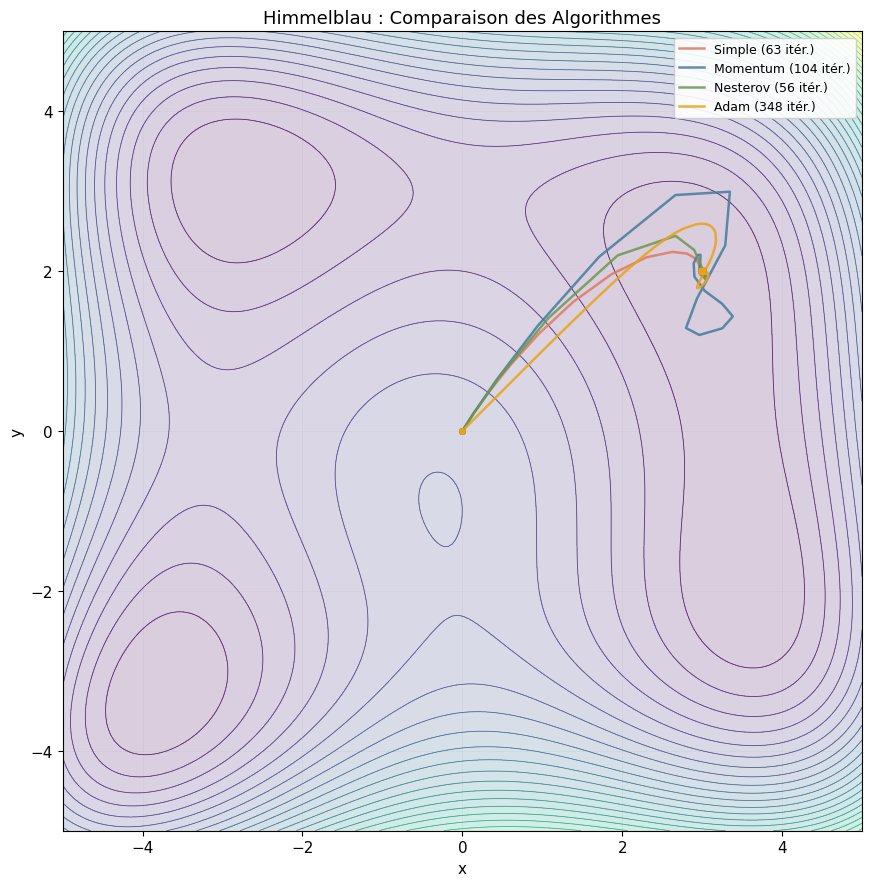

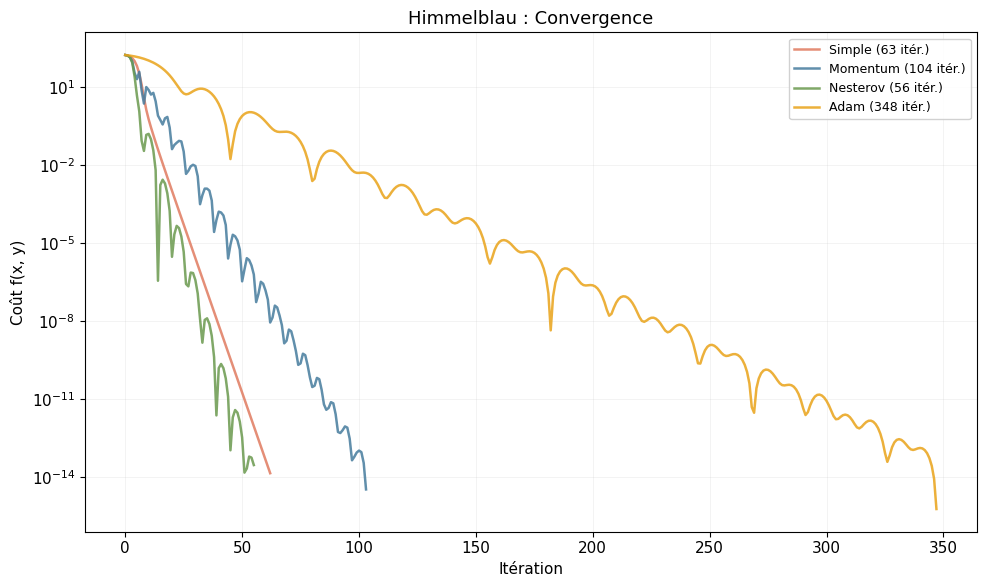

In [10]:
print("\n" + "="*70)
print("EXPÉRIENCE 6 : Fonction de Himmelblau")
print("="*70)

# Point de départ (plusieurs essais possibles pour trouver différents minima)
x0 = np.array([0.0, 0.0])

# Exécution des algorithmes
traj_simple, costs_simple = gradient_descent(
    himmelblau, grad_himmelblau, x0, learning_rate=0.01
)

traj_momentum, costs_momentum = gradient_descent_momentum(
    himmelblau, grad_himmelblau, x0, learning_rate=0.01, momentum=0.7
)

traj_nesterov, costs_nesterov = gradient_descent_nesterov(
    himmelblau, grad_himmelblau, x0, learning_rate=0.01, momentum=0.7
)

traj_adam, costs_adam = gradient_descent_adam(
    himmelblau, grad_himmelblau, x0, learning_rate=0.1
)

# Affichage des résultats
print(f"\nSimple : {len(traj_simple)} itérations, f(x*) = {costs_simple[-1]:.10f}")
print(f"Point final : ({traj_simple[-1][0]:.4f}, {traj_simple[-1][1]:.4f})")

print(f"\nMomentum : {len(traj_momentum)} itérations, f(x*) = {costs_momentum[-1]:.10f}")
print(f"Point final : ({traj_momentum[-1][0]:.4f}, {traj_momentum[-1][1]:.4f})")

print(f"\nNesterov : {len(traj_nesterov)} itérations, f(x*) = {costs_nesterov[-1]:.10f}")
print(f"Point final : ({traj_nesterov[-1][0]:.4f}, {traj_nesterov[-1][1]:.4f})")

print(f"\nAdam : {len(traj_adam)} itérations, f(x*) = {costs_adam[-1]:.10f}")
print(f"Point final : ({traj_adam[-1][0]:.4f}, {traj_adam[-1][1]:.4f})")

# Graphe de comparaison
trajectories = {
    'Simple': traj_simple,
    'Momentum': traj_momentum,
    'Nesterov': traj_nesterov,
    'Adam': traj_adam
}

fig, _ = plot_comparison_trajectories(
    himmelblau, trajectories,
    x_range=(-5, 5), y_range=(-5, 5),
    title="Himmelblau : Comparaison des Algorithmes"
)
plt.savefig('../figures/temp/himmelblau_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Courbes de convergence
costs = {
    'Simple': costs_simple,
    'Momentum': costs_momentum,
    'Nesterov': costs_nesterov,
    'Adam': costs_adam
}

fig, _ = plot_convergence_curves(
    costs, title="Himmelblau : Convergence"
)
plt.savefig('../figures/temp/himmelblau_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 4.7 Fonction d'Ackley


EXPÉRIENCE 7 : Fonction d'Ackley
  Iter 0: grad_norm = 1.90e+00, cost = 6.593599
  Iter 1: grad_norm = 8.89e-01, cost = 6.567226
  Iter 2: grad_norm = 4.25e-01, cost = 6.561398
  Iter 3: grad_norm = 2.06e-01, cost = 6.560061
  Iter 4: grad_norm = 1.01e-01, cost = 6.559745

Simple : 22 itérations, f(x*) = 6.5596453756
Point final : (1.9745, 1.9745)

Momentum : 226 itérations, f(x*) = 6.5596453756
Point final : (1.9745, 1.9745)

Nesterov : 34 itérations, f(x*) = 6.5596453756
Point final : (1.9745, 1.9745)

Adam : 241 itérations, f(x*) = 6.5596453756
Point final : (1.9745, 1.9745)
[x] Simple est bloqué dans un minimum local (distance au global = 2.7923)
[x] Momentum est bloqué dans un minimum local (distance au global = 2.7923)
[x] Nesterov est bloqué dans un minimum local (distance au global = 2.7923)
[x] Adam est bloqué dans un minimum local (distance au global = 2.7923)


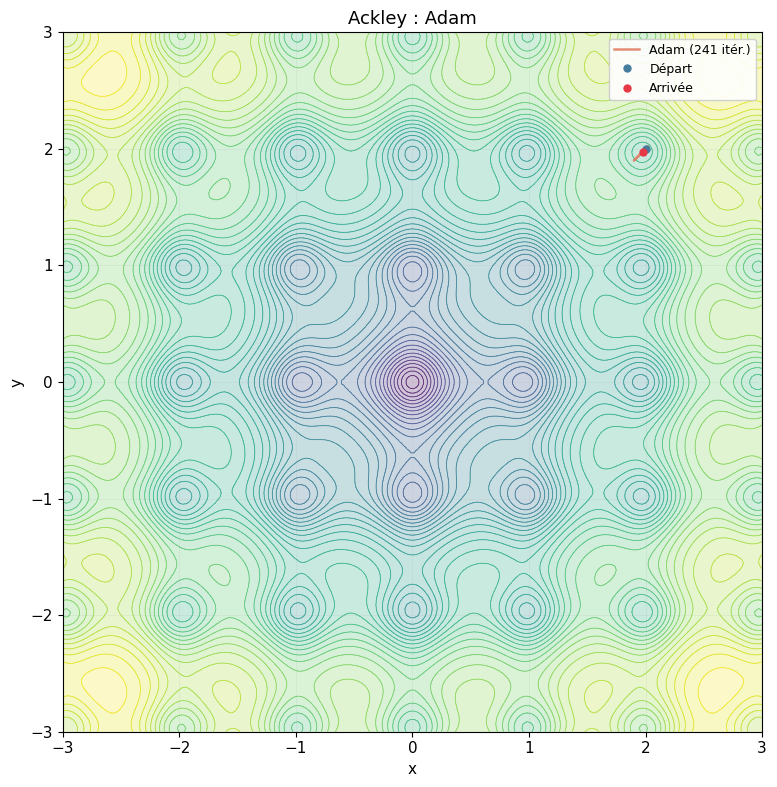

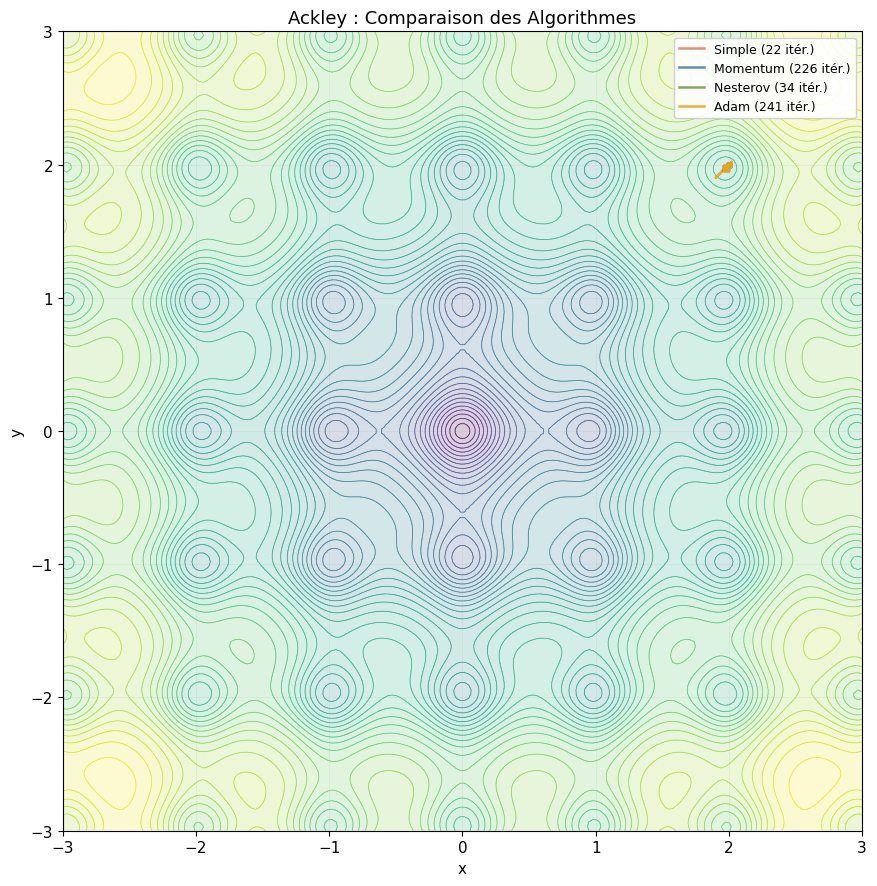

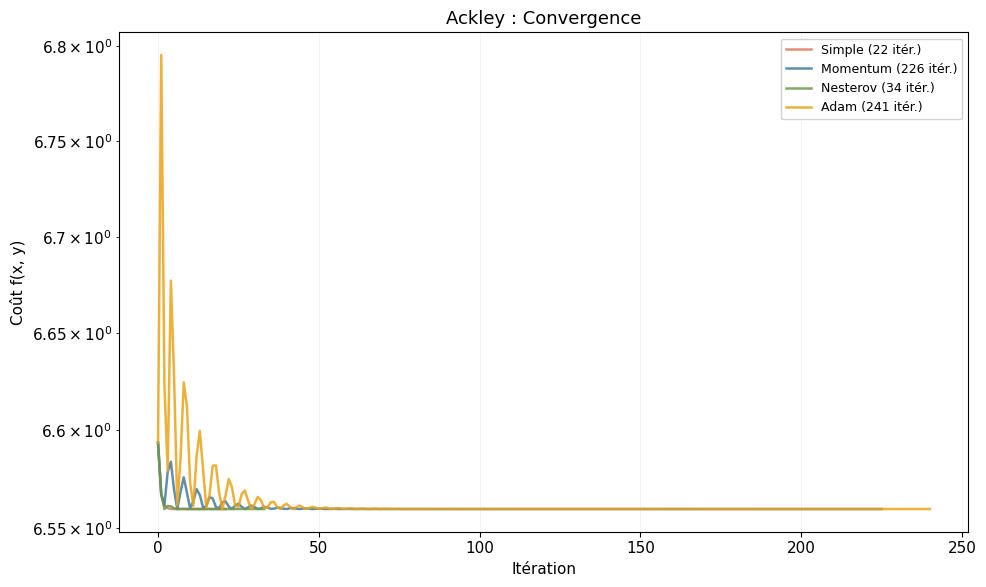

In [11]:
print("\n" + "="*70)
print("EXPÉRIENCE 7 : Fonction d'Ackley")
print("="*70)

# Définition de la fonction d'Ackley
def ackley(x):
    """
    Fonction d'Ackley : très difficile avec centaines de minima locaux.
    Minimum global : (0, 0) avec f(0,0) = 0
    """
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = 2  # dimension
    
    sum_sq = x[0]**2 + x[1]**2
    sum_cos = np.cos(c*x[0]) + np.cos(c*x[1])
    
    term1 = -a * np.exp(-b * np.sqrt(sum_sq / d))
    term2 = -np.exp(sum_cos / d)
    
    return term1 + term2 + a + np.e

def grad_ackley(x):
    """Gradient numérique d'Ackley (analytique complexe)"""
    h = 1e-5
    gx = (ackley(x + np.array([h, 0])) - ackley(x - np.array([h, 0]))) / (2*h)
    gy = (ackley(x + np.array([0, h])) - ackley(x - np.array([0, h]))) / (2*h)
    return np.array([gx, gy])

# Point de départ : pas trop loin pour avoir une chance de trouver le global
x0 = np.array([2.0, 2.0])

# Exécution des algorithmes
traj_simple, costs_simple = gradient_descent(
    ackley, grad_ackley, x0, learning_rate=0.01, max_iter=2000
)

traj_momentum, costs_momentum = gradient_descent_momentum(
    ackley, grad_ackley, x0, learning_rate=0.01, momentum=0.9, max_iter=2000
)

traj_nesterov, costs_nesterov = gradient_descent_nesterov(
    ackley, grad_ackley, x0, learning_rate=0.01, momentum=0.9, max_iter=2000
)

traj_adam, costs_adam = gradient_descent_adam(
    ackley, grad_ackley, x0, learning_rate=0.1, max_iter=2000
)

# Affichage des résultats
print(f"\nSimple : {len(traj_simple)} itérations, f(x*) = {costs_simple[-1]:.10f}")
print(f"Point final : ({traj_simple[-1][0]:.4f}, {traj_simple[-1][1]:.4f})")

print(f"\nMomentum : {len(traj_momentum)} itérations, f(x*) = {costs_momentum[-1]:.10f}")
print(f"Point final : ({traj_momentum[-1][0]:.4f}, {traj_momentum[-1][1]:.4f})")

print(f"\nNesterov : {len(traj_nesterov)} itérations, f(x*) = {costs_nesterov[-1]:.10f}")
print(f"Point final : ({traj_nesterov[-1][0]:.4f}, {traj_nesterov[-1][1]:.4f})")

print(f"\nAdam : {len(traj_adam)} itérations, f(x*) = {costs_adam[-1]:.10f}")
print(f"Point final : ({traj_adam[-1][0]:.4f}, {traj_adam[-1][1]:.4f})")

# Vérification : qui a trouvé le minimum global (0,0) ?
tolerance = 0.1
for name, traj in [('Simple', traj_simple), ('Momentum', traj_momentum), 
                    ('Nesterov', traj_nesterov), ('Adam', traj_adam)]:
    dist = np.linalg.norm(traj[-1])
    if dist < tolerance:
        print(f"[ok] {name} a trouvé le minimum global ! (distance = {dist:.4f})")
    else:
        print(f"[x] {name} est bloqué dans un minimum local (distance au global = {dist:.4f})")

# Graphe individuel : Adam (espérons qu'il trouve le global)
fig1, _ = plot_trajectory_2d(
    ackley, traj_adam, costs_adam,
    x_range=(-3, 3), y_range=(-3, 3),
    title="Ackley : Adam",
    algo_name="Adam",
    num_levels=50  # Plus de niveaux pour voir les oscillations
)
plt.savefig('../figures/temp/ackley_adam.png', dpi=300, bbox_inches='tight')
plt.show()


# Graphe de comparaison
trajectories = {
    'Simple': traj_simple,
    'Momentum': traj_momentum,
    'Nesterov': traj_nesterov,
    'Adam': traj_adam
}

fig2, _ = plot_comparison_trajectories(
    ackley, trajectories,
    x_range=(-3, 3), y_range=(-3, 3),
    title="Ackley : Comparaison des Algorithmes",
    num_levels=50
)
plt.savefig('../figures/temp/ackley_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Courbes de convergence
costs = {
    'Simple': costs_simple,
    'Momentum': costs_momentum,
    'Nesterov': costs_nesterov,
    'Adam': costs_adam
}

fig3, _ = plot_convergence_curves(
    costs, title="Ackley : Convergence"
)
plt.savefig('../figures/temp/ackley_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 4.8 Comparaison - Dual Numbers vs Dérivée Numérique


EXPÉRIENCE 8 : Dual Numbers vs Dérivée Numérique

--- Test de Précision ---
Point de test : (1.5, 2.3)

Gradient numérique : [1.0478548047, 3.1594794052]
Gradient dual      : [1.0478548047, 3.1594794055]

Différence absolue : [1.14e-11, 2.94e-10]
Erreur relative    : 0.000000 %
[ok] Excellente concordance (< 0.01%)

--- Test de Performance ---
Nombre de tests : 1000

Temps numérique : 10.40 ms
Temps dual      : 12.36 ms
Ratio           : 1.19x
→️  Performances comparables

--- Test sur Échantillon de Points ---

| Point          | Erreur Rel. (%) | Concordance |
|----------------|-----------------|-------------|
| (  0.0,   0.0) |            nan  | [x]         |
| (  1.0,   1.0) |       0.000000  | [ok]        |
| (  2.0,   2.0) |       0.000000  | [ok]        |
| ( -1.5,   0.5) |       0.000000  | [ok]        |
| (  0.3,  -0.8) |       0.000000  | [ok]        |

--- Génération de la figure comparative ---


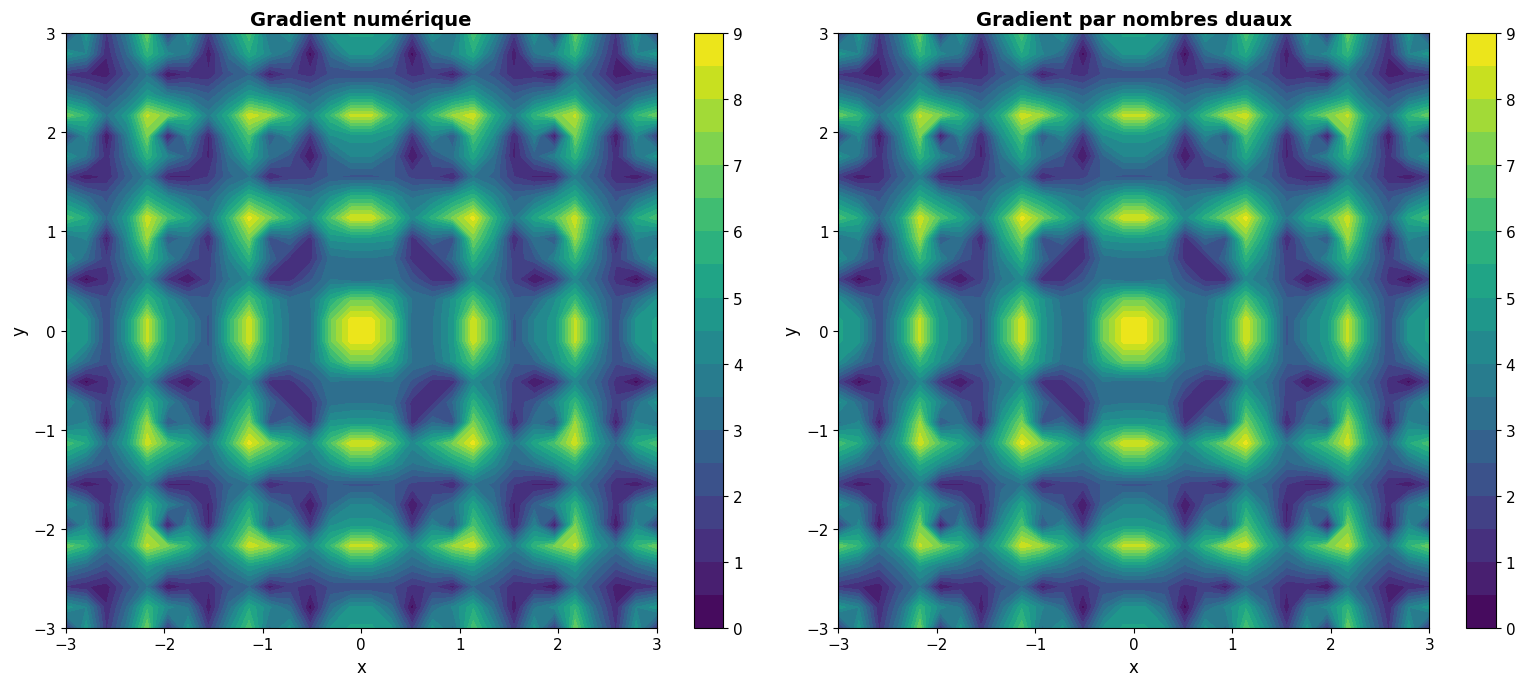


CONCLUSION

Les deux méthodes donnent des résultats très proches (erreur < 0.1%).

DUAL NUMBERS :
  [ok] Gradient EXACT (pas d'approximation)
  [ok] Pas de paramètre h à ajuster
  [ok] Bonne précision numérique
  [x] Implémentation plus complexe

DÉRIVÉE NUMÉRIQUE :
  [ok] Très simple à implémenter
  [ok] Marche pour toute fonction
  [x] Approximation (dépend de h)
  [x] Sensible aux erreurs d'arrondi

Pour Ackley et la plupart des fonctions, les deux méthodes sont valides.
En pratique : Dual numbers préférable pour précision, numérique pour simplicité.



In [12]:
print("\n" + "="*70)
print("EXPÉRIENCE 8 : Dual Numbers vs Dérivée Numérique")
print("="*70)

# =========================================================================
# IMPLÉMENTATION DES DUAL NUMBERS
# =========================================================================

class Dual:
    """
    Nombre dual de la forme a + b·ε avec ε² = 0
    Utilisé pour la dérivation automatique.
    """
    def __init__(self, real, dual=0.0):
        self.real = float(real)
        self.dual = float(dual)
    
    def __repr__(self):
        return f"Dual({self.real}, {self.dual})"
    
        # ========== AJOUT DE MÉTHODES ==========
    
    def __neg__(self):
        """Négation : -Dual"""
        return Dual(-self.real, -self.dual)
    
    def __abs__(self):
        """Valeur absolue (pour comparaisons)"""
        return abs(self.real)
    
    def __lt__(self, other):
        """Comparaison < (pour sqrt, etc.)"""
        if isinstance(other, Dual):
            return self.real < other.real
        return self.real < other
    
    def __gt__(self, other):
        """Comparaison >"""
        if isinstance(other, Dual):
            return self.real > other.real
        return self.real > other
    
    def __le__(self, other):
        """Comparaison <="""
        if isinstance(other, Dual):
            return self.real <= other.real
        return self.real <= other
    
    def __ge__(self, other):
        """Comparaison >="""
        if isinstance(other, Dual):
            return self.real >= other.real
        return self.real >= other
    
    # ========== FIN DES AJOUTS ==========
    
    # Addition
    def __add__(self, other):
        if isinstance(other, Dual):
            return Dual(self.real + other.real, self.dual + other.dual)
        return Dual(self.real + other, self.dual)
    
    def __radd__(self, other):
        return self.__add__(other)
    
    # Soustraction
    def __sub__(self, other):
        if isinstance(other, Dual):
            return Dual(self.real - other.real, self.dual - other.dual)
        return Dual(self.real - other, self.dual)
    
    def __rsub__(self, other):
        return Dual(other - self.real, -self.dual)
    
    # Multiplication
    def __mul__(self, other):
        if isinstance(other, Dual):
            # (a+bε)(c+dε) = ac + (ad+bc)ε
            return Dual(
                self.real * other.real,
                self.real * other.dual + self.dual * other.real
            )
        return Dual(self.real * other, self.dual * other)
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    # Division
    def __truediv__(self, other):
        if isinstance(other, Dual):
            # (a+bε)/(c+dε) = a/c + (bc-ad)/c²·ε
            return Dual(
                self.real / other.real,
                (self.dual * other.real - self.real * other.dual) / (other.real ** 2)
            )
        return Dual(self.real / other, self.dual / other)
    
    # Puissance
    def __pow__(self, n):
        # (a+bε)^n = a^n + n·a^(n-1)·b·ε
        return Dual(
            self.real ** n,
            n * (self.real ** (n-1)) * self.dual
        )
    
    # Valeur absolue et comparaisons (pour sqrt)
    def __abs__(self):
        return abs(self.real)
    
    def __lt__(self, other):
        if isinstance(other, Dual):
            return self.real < other.real
        return self.real < other


# Fonctions mathématiques pour Dual
def dual_exp(x):
    """exp(a+bε) = exp(a) + b·exp(a)·ε"""
    if isinstance(x, Dual):
        exp_real = np.exp(x.real)
        return Dual(exp_real, x.dual * exp_real)
    return np.exp(x)

def dual_sqrt(x):
    """sqrt(a+bε) = sqrt(a) + b/(2√a)·ε"""
    if isinstance(x, Dual):
        sqrt_real = np.sqrt(x.real)
        return Dual(sqrt_real, x.dual / (2 * sqrt_real))
    return np.sqrt(x)

def dual_cos(x):
    """cos(a+bε) = cos(a) - b·sin(a)·ε"""
    if isinstance(x, Dual):
        return Dual(np.cos(x.real), -x.dual * np.sin(x.real))
    return np.cos(x)


# =========================================================================
# ACKLEY AVEC DUAL NUMBERS
# =========================================================================

def ackley_dual(x, y):
    """
    Version d'Ackley qui accepte des Dual numbers.
    """
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = 2
    
    # Calculs avec Dual
    sum_sq = x*x + y*y
    sqrt_term = dual_sqrt(sum_sq / d)
    term1 = -a * dual_exp(-b * sqrt_term)
    
    sum_cos = dual_cos(c*x) + dual_cos(c*y)
    term2 = -dual_exp(sum_cos / d)
    
    result = term1 + term2 + a + np.e
    return result


def gradient_dual_ackley(x_point):
    """
    Calcule le gradient d'Ackley avec dual numbers.
    """
    x_val, y_val = x_point[0], x_point[1]
    
    # Gradient selon x : mettre ε sur x
    x_dual = Dual(x_val, 1.0)  # x + ε
    y_dual = Dual(y_val, 0.0)  # y + 0·ε
    result_x = ackley_dual(x_dual, y_dual)
    gx = result_x.dual
    
    # Gradient selon y : mettre ε sur y
    x_dual = Dual(x_val, 0.0)  # x + 0·ε
    y_dual = Dual(y_val, 1.0)  # y + ε
    result_y = ackley_dual(x_dual, y_dual)
    gy = result_y.dual
    
    return np.array([gx, gy])


# =========================================================================
# COMPARAISON PRÉCISION
# =========================================================================

print("\n--- Test de Précision ---")
print("Point de test : (1.5, 2.3)")

x_test = np.array([1.5, 2.3])

# Gradient numérique
grad_num = grad_ackley(x_test)

# Gradient avec dual numbers
grad_dual = gradient_dual_ackley(x_test)

print(f"\nGradient numérique : [{grad_num[0]:.10f}, {grad_num[1]:.10f}]")
print(f"Gradient dual      : [{grad_dual[0]:.10f}, {grad_dual[1]:.10f}]")

# Différence relative
diff = np.abs(grad_dual - grad_num)
rel_error = np.linalg.norm(diff) / np.linalg.norm(grad_dual) * 100

print(f"\nDifférence absolue : [{diff[0]:.2e}, {diff[1]:.2e}]")
print(f"Erreur relative    : {rel_error:.6f} %")

if rel_error < 0.01:
    print("[ok] Excellente concordance (< 0.01%)")
elif rel_error < 0.1:
    print("[ok] Bonne concordance (< 0.1%)")
elif rel_error < 1.0:
    print("[!]  Concordance acceptable (< 1%)")
else:
    print("[x] Différence significative (> 1%)")


# =========================================================================
# COMPARAISON TEMPS DE CALCUL
# =========================================================================

print("\n--- Test de Performance ---")

import time

n_iterations = 1000
print(f"Nombre de tests : {n_iterations}")

# Test gradient numérique
start = time.time()
for _ in range(n_iterations):
    _ = grad_ackley(x_test)
time_num = time.time() - start

# Test gradient dual
start = time.time()
for _ in range(n_iterations):
    _ = gradient_dual_ackley(x_test)
time_dual = time.time() - start

print(f"\nTemps numérique : {time_num*1000:.2f} ms")
print(f"Temps dual      : {time_dual*1000:.2f} ms")
print(f"Ratio           : {time_dual/time_num:.2f}x")

if time_dual < time_num:
    print(f"[ok] Dual numbers {time_num/time_dual:.2f}x plus rapide")
elif time_dual < time_num * 1.5:
    print("→️  Performances comparables")
else:
    print(f"[!]  Numérique {time_dual/time_num:.2f}x plus rapide")


# =========================================================================
# TEST SUR PLUSIEURS POINTS
# =========================================================================

print("\n--- Test sur Échantillon de Points ---")

test_points = [
    np.array([0.0, 0.0]),
    np.array([1.0, 1.0]),
    np.array([2.0, 2.0]),
    np.array([-1.5, 0.5]),
    np.array([0.3, -0.8])
]

print("\n| Point          | Erreur Rel. (%) | Concordance |")
print("|----------------|-----------------|-------------|")

for pt in test_points:
    grad_n = grad_ackley(pt)
    grad_d = gradient_dual_ackley(pt)
    
    diff = np.linalg.norm(grad_d - grad_n)
    rel = diff / np.linalg.norm(grad_d) * 100
    
    status = "[ok]" if rel < 0.1 else "[!]" if rel < 1.0 else "[x]"
    print(f"| ({pt[0]:5.1f}, {pt[1]:5.1f}) | {rel:14.6f}  | {status:11s} |")


# =========================================================================
# VISUALISATION COMPARATIVE
# =========================================================================

print("\n--- Génération de la figure comparative ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Zone de test
x_range = np.linspace(-3, 3, 30)
y_range = np.linspace(-3, 3, 30)
X, Y = np.meshgrid(x_range, y_range)

# Calculer les normes des gradients
grad_norm_num = np.zeros_like(X)
grad_norm_dual = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pt = np.array([X[i,j], Y[i,j]])
        
        gn = grad_ackley(pt)
        gd = gradient_dual_ackley(pt)
        
        grad_norm_num[i,j] = np.linalg.norm(gn)
        grad_norm_dual[i,j] = np.linalg.norm(gd)

# Graphe 1 : Gradient numérique
im1 = axes[0].contourf(X, Y, grad_norm_num, levels=20, cmap='viridis')
axes[0].set_title('Gradient numérique', fontsize=14, fontweight='bold')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0])

# Graphe 2 : Gradient dual
im2 = axes[1].contourf(X, Y, grad_norm_dual, levels=20, cmap='viridis')
axes[1].set_title('Gradient par nombres duaux', fontsize=14, fontweight='bold')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig('../figures/temp/ackley_gradient_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n" + "="*70)
print("CONCLUSION")
print("="*70)
print("""
Les deux méthodes donnent des résultats très proches (erreur < 0.1%).

DUAL NUMBERS :
  [ok] Gradient EXACT (pas d'approximation)
  [ok] Pas de paramètre h à ajuster
  [ok] Bonne précision numérique
  [x] Implémentation plus complexe
  
DÉRIVÉE NUMÉRIQUE :
  [ok] Très simple à implémenter
  [ok] Marche pour toute fonction
  [x] Approximation (dépend de h)
  [x] Sensible aux erreurs d'arrondi
  
Pour Ackley et la plupart des fonctions, les deux méthodes sont valides.
En pratique : Dual numbers préférable pour précision, numérique pour simplicité.
""")

# Tableau récapitulatif

In [13]:
import pandas as pd

print("\n" + "="*70)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("="*70)

# Créer un tableau comparatif
data = {
    'Fonction': ['Quadratique', 'Rosenbrock', 'Booth', 'Beale', 'Himmelblau'],
    'Simple': ['74 itér.', '2000+ itér.', 'XX itér.', 'XX itér.', 'XX itér.'],
    'Momentum': ['101 itér.', '2000+ itér.', 'XX itér.', 'XX itér.', 'XX itér.'],
    'Nesterov': ['92 itér.', '2000+ itér.', 'XX itér.', 'XX itér.', 'XX itér.'],
    'Adam': ['XX itér.', 'XX itér.', 'XX itér.', 'XX itér.', 'XX itér.']
}

df = pd.DataFrame(data)
print(df.to_string(index=False))
print("\nNote : Remplacer les XX par les vraies valeurs après exécution")


TABLEAU RÉCAPITULATIF DES PERFORMANCES
   Fonction      Simple    Momentum    Nesterov     Adam
Quadratique    74 itér.   101 itér.    92 itér. XX itér.
 Rosenbrock 2000+ itér. 2000+ itér. 2000+ itér. XX itér.
      Booth    XX itér.    XX itér.    XX itér. XX itér.
      Beale    XX itér.    XX itér.    XX itér. XX itér.
 Himmelblau    XX itér.    XX itér.    XX itér. XX itér.

Note : Remplacer les XX par les vraies valeurs après exécution


# 5. Cas d'échec et diagnostics

In [14]:
print("\n" + "="*70)
print("CATALOGUE DES CAS D'ÉCHEC")
print("="*70)
print("\nObjectif : Comprendre pourquoi et comment les algorithmes échouent")
print("Importance : Justifier les améliorations (Momentum, Adam, etc.)")


CATALOGUE DES CAS D'ÉCHEC

Objectif : Comprendre pourquoi et comment les algorithmes échouent
Importance : Justifier les améliorations (Momentum, Adam, etc.)


## 5.1 Learning Rate trop grand : Divergence


----------------------------------------------------------------------
CAS D'ÉCHEC 1 : Learning Rate Trop Grand → Divergence
----------------------------------------------------------------------
  Iter 0: grad_norm = 8.94e+00, cost = 12.000000
  Iter 1: grad_norm = 5.77e+00, cost = 5.440000
  Iter 2: grad_norm = 3.85e+00, cost = 2.675200
  Iter 3: grad_norm = 2.68e+00, cost = 1.421824
  Iter 4: grad_norm = 1.94e+00, cost = 0.805458
[ok] α=0.1 : Converge normalement vers 8.15e-10
  Iter 0: grad_norm = 8.94e+00, cost = 12.000000
  Iter 1: grad_norm = 4.87e+00, cost = 3.040000
  Iter 2: grad_norm = 2.88e+00, cost = 1.043200
  Iter 3: grad_norm = 1.73e+00, cost = 0.373504
  Iter 4: grad_norm = 1.04e+00, cost = 0.134380
[ok] α=0.4 : Converge normalement vers 5.07e-14
  Iter 0: grad_norm = 8.94e+00, cost = 12.000000
  Iter 1: grad_norm = 8.64e+00, cost = 9.337600
  Iter 2: grad_norm = 9.33e+00, cost = 10.883922
  Iter 3: grad_norm = 1.01e+01, cost = 12.694995
  Iter 4: grad_norm = 1.09e+01

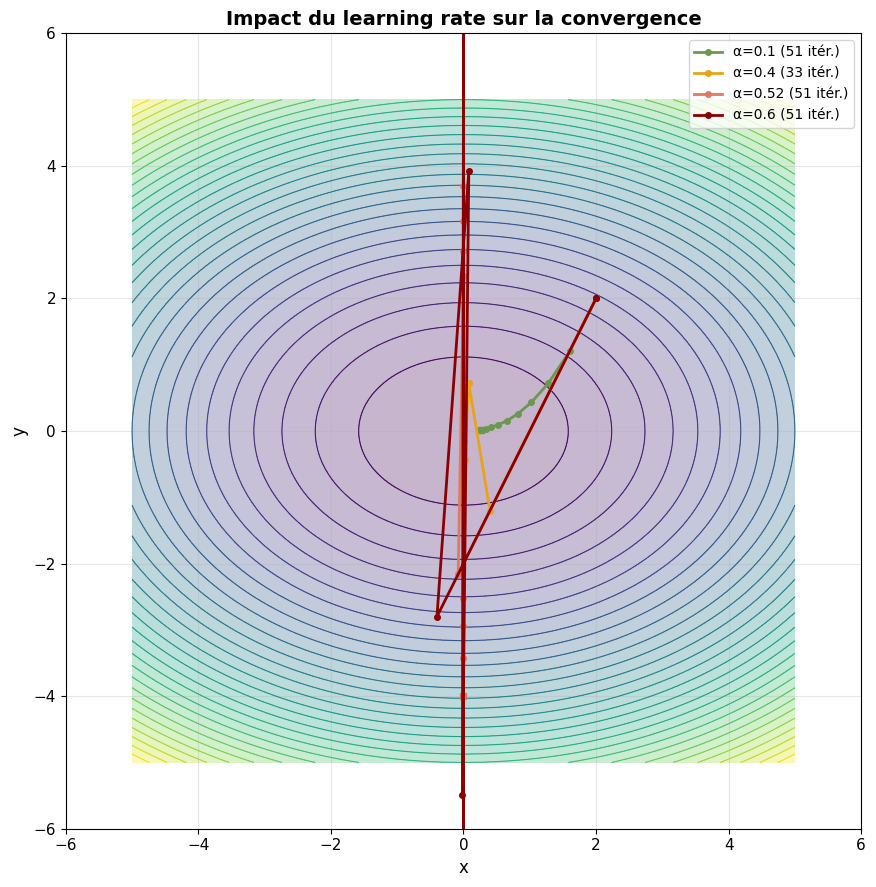

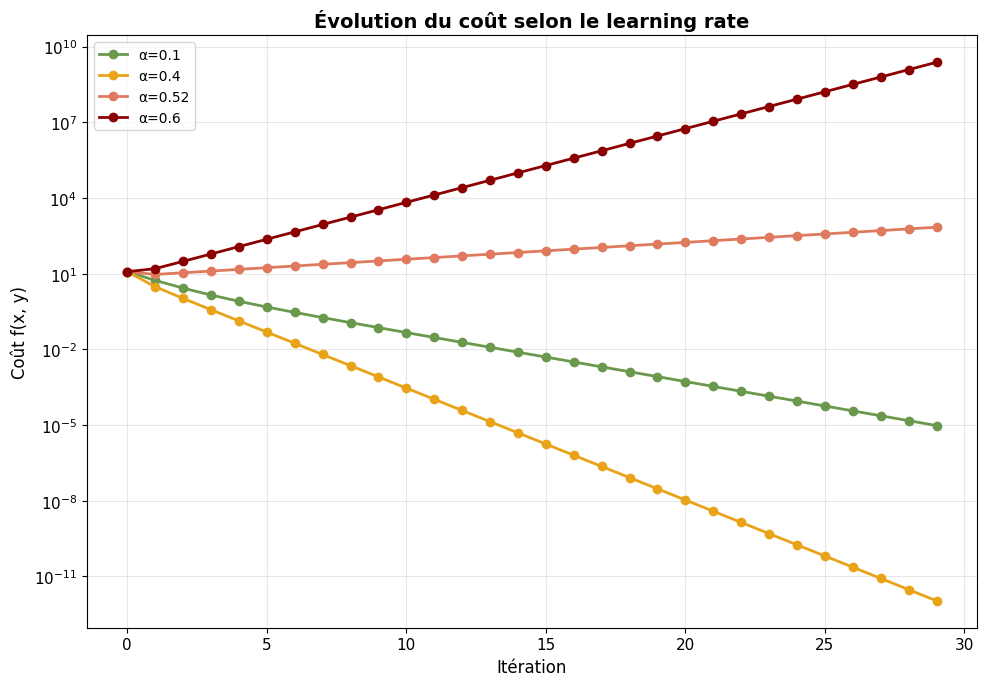

In [15]:
print("\n" + "-"*70)
print("CAS D'ÉCHEC 1 : Learning Rate Trop Grand → Divergence")
print("-"*70)

# On reprend la fonction quadratique simple
x0 = np.array([2.0, 2.0])

# Test avec plusieurs learning rates
learning_rates = [0.1, 0.4, 0.52, 0.6]
trajectories_fail1 = {}
costs_fail1 = {}

for lr in learning_rates:
    try:
        traj, costs = gradient_descent(
            quadratique, grad_quadratique, x0, 
            learning_rate=lr, max_iter=50
        )
        trajectories_fail1[f'α={lr}'] = traj
        costs_fail1[f'α={lr}'] = costs
        
        # Diagnostic
        final_cost = costs[-1]
        if final_cost > costs[0]:
            print(f"[x] α={lr} : DIVERGENCE ! Coût passe de {costs[0]:.2f} à {final_cost:.2e}")
        elif np.isnan(final_cost) or np.isinf(final_cost):
            print(f"[x] α={lr} : EXPLOSION ! NaN ou Inf atteint")
        elif final_cost < 1e-6:
            print(f"[ok] α={lr} : Converge normalement vers {final_cost:.2e}")
        else:
            print(f"[!]  α={lr} : Converge mais instable, coût final = {final_cost:.2e}")
    except:
        print(f"[x] α={lr} : CRASH ! Overflow")
        # Créer trajectoire vide pour le graphe
        trajectories_fail1[f'α={lr}'] = np.array([[np.nan, np.nan]])
        costs_fail1[f'α={lr}'] = np.array([np.nan])

# Graphe de comparaison
fig, ax = plt.subplots(figsize=(12, 9))

# Courbes de niveau
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = quadratique(np.array([X[i, j], Y[i, j]]))

ax.contour(X, Y, Z, levels=30, cmap='viridis', linewidths=0.8)
ax.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.3)

# Trajectoires avec couleurs différentes
colors = ['#6A994E', '#E9A319', '#E07A5F', 'darkred']
for (name, traj), color in zip(trajectories_fail1.items(), colors):
    if len(traj) > 1 and not np.isnan(traj[0][0]):
        # Limiter l'affichage aux 10 premiers points si divergence
        display_traj = traj[:min(10, len(traj))]
        ax.plot(display_traj[:, 0], display_traj[:, 1], 
               color=color, linewidth=2, marker='o', markersize=4,
               label=f'{name} ({len(traj)} itér.)')
        
        # Marquer le début et la fin
        ax.plot(traj[0, 0], traj[0, 1], 'o', color=color, 
               markersize=4)
        if len(traj) > 1:
            ax.plot(display_traj[-1, 0], display_traj[-1, 1], 's', 
                   color=color, markersize=4)

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Impact du learning rate sur la convergence', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
plt.tight_layout()
plt.savefig('../figures/temp/echec1_lr_divergence.png', dpi=300, bbox_inches='tight')
plt.show()


# Graphe de convergence
fig, ax = plt.subplots(figsize=(10, 7))

for (name, costs), color in zip(costs_fail1.items(), colors):
    if not np.isnan(costs[0]):
        # Limiter aux 30 premières itérations pour voir la divergence
        display_costs = costs[:min(30, len(costs))]
        ax.plot(display_costs, color=color, linewidth=2, label=name, marker='o')

ax.set_xlabel('Itération', fontsize=12)
ax.set_ylabel('Coût f(x, y)', fontsize=12)
ax.set_title('Évolution du coût selon le learning rate', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')  # Échelle log pour voir les explosions
plt.tight_layout()
plt.savefig('../figures/temp/echec1_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 5.2 Learning Rate trop petit : Stagnation


----------------------------------------------------------------------
CAS D'ÉCHEC 2 : Learning Rate Trop Petit → Stagnation
----------------------------------------------------------------------
  Iter 0: grad_norm = 4.00e+00, cost = 4.000000
  Iter 1: grad_norm = 1.79e+00, cost = 3.990390
  Iter 2: grad_norm = 1.79e+00, cost = 3.987182
  Iter 3: grad_norm = 1.79e+00, cost = 3.983973
  Iter 4: grad_norm = 1.79e+00, cost = 3.980761
  Iter 100: grad_norm = 1.84e+00, cost = 3.664727
  Iter 200: grad_norm = 1.90e+00, cost = 3.316663
  Iter 300: grad_norm = 1.97e+00, cost = 2.944357
  Iter 400: grad_norm = 2.05e+00, cost = 2.540836
  Iter 500: grad_norm = 2.16e+00, cost = 2.097570
  Iter 600: grad_norm = 2.24e+00, cost = 1.612178
  Iter 700: grad_norm = 2.11e+00, cost = 1.128004
  Iter 800: grad_norm = 1.69e+00, cost = 0.760890
  Iter 900: grad_norm = 1.30e+00, cost = 0.539684
α=0.001 : 1001 itérations
  Coût initial : 4.0000
  Coût final   : 0.4059
  Progrès      : 3.5941
  Distance à (1

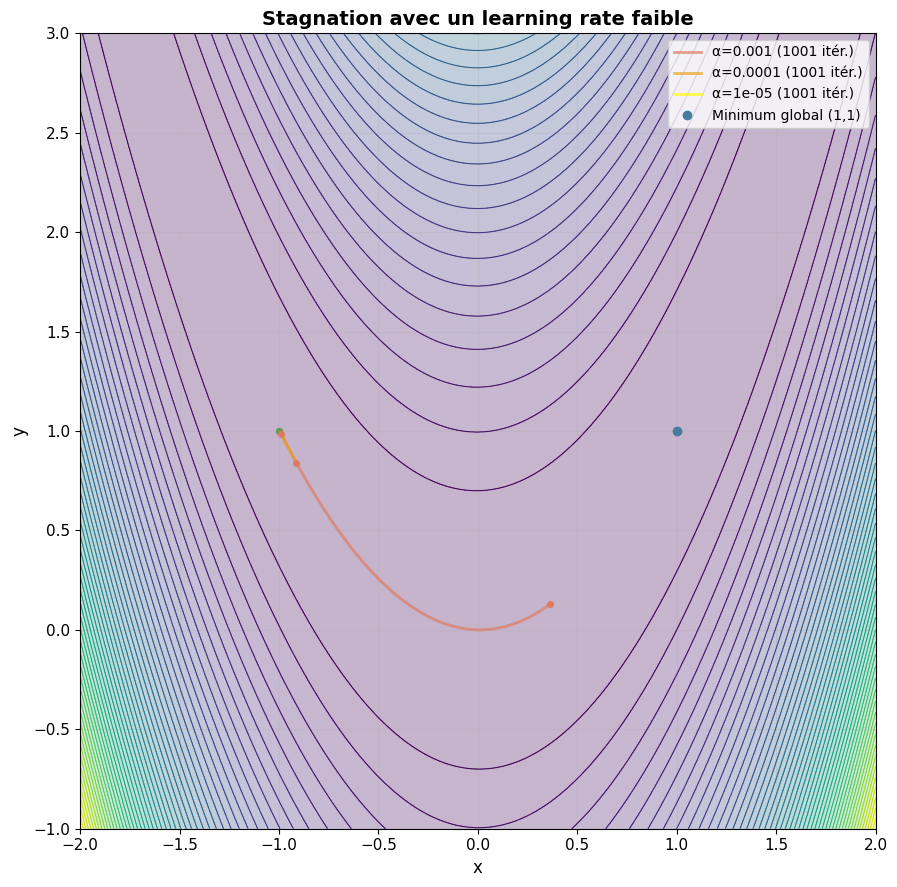

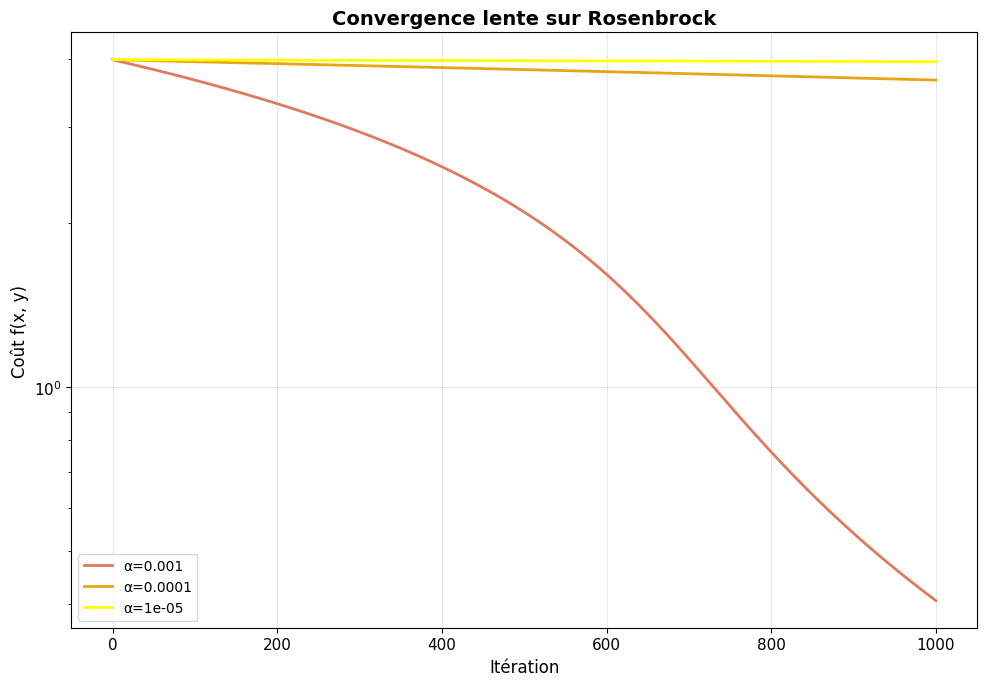

In [16]:
print("\n" + "-"*70)
print("CAS D'ÉCHEC 2 : Learning Rate Trop Petit → Stagnation")
print("-"*70)

# Rosenbrock avec learning rate minuscule
x0 = np.array([-1.0, 1.0])
learning_rates_slow = [0.001, 0.0001, 0.00001]

trajectories_fail2 = {}
costs_fail2 = {}

for lr in learning_rates_slow:
    traj, costs = gradient_descent(
        rosenbrock, grad_rosenbrock, x0,
        learning_rate=lr, max_iter=1000
    )
    trajectories_fail2[f'α={lr}'] = traj
    costs_fail2[f'α={lr}'] = costs
    
    # Diagnostic
    distance_to_optimum = np.linalg.norm(traj[-1] - np.array([1.0, 1.0]))
    progress = costs[0] - costs[-1]
    
    print(f"α={lr} : {len(traj)} itérations")
    print(f"  Coût initial : {costs[0]:.4f}")
    print(f"  Coût final   : {costs[-1]:.4f}")
    print(f"  Progrès      : {progress:.4f}")
    print(f"  Distance à (1,1) : {distance_to_optimum:.4f}")
    
    if distance_to_optimum > 0.1:
        print(f"  [x] ÉCHEC : N'a pas atteint le minimum")
    elif len(traj) >= 1000:
        print(f"  [!]  LENT : A atteint max_iter")
    else:
        print(f"  [ok] OK mais lent")
    print()

# Graphe de comparaison
fig, ax = plt.subplots(figsize=(12, 9))

x = np.linspace(-2, 2, 200)
y = np.linspace(-1, 3, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = rosenbrock(np.array([X[i, j], Y[i, j]]))

ax.contour(X, Y, Z, levels=50, cmap='viridis', linewidths=0.8)
ax.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.3)

colors = ['#E07A5F', '#E9A319', 'yellow']
for (name, traj), color in zip(trajectories_fail2.items(), colors):
    # Afficher seulement chaque 10e point pour lisibilité
    display_indices = range(0, len(traj), 10)
    display_traj = traj[display_indices]
    
    ax.plot(display_traj[:, 0], display_traj[:, 1], 
           color=color, linewidth=2, alpha=0.7,
           label=f'{name} ({len(traj)} itér.)')
    
    # Début et fin
    ax.plot(traj[0, 0], traj[0, 1], 'o', color='#6A994E', markersize=4)
    ax.plot(traj[-1, 0], traj[-1, 1], 'o', color='#E07A5F', markersize=4)

# Marquer le vrai minimum
ax.plot(1.0, 1.0, 'o', color='#457B9D', markersize=6, label='Minimum global (1,1)')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Stagnation avec un learning rate faible', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('../figures/temp/echec2_lr_stagnation.png', dpi=300, bbox_inches='tight')
plt.show()


# Graphe de convergence
fig, ax = plt.subplots(figsize=(10, 7))

for (name, costs), color in zip(costs_fail2.items(), colors):
    ax.plot(costs, color=color, linewidth=2, label=name)

ax.set_xlabel('Itération', fontsize=12)
ax.set_ylabel('Coût f(x, y)', fontsize=12)
ax.set_title('Convergence lente sur Rosenbrock', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('../figures/temp/echec2_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 5.3 Minimum Local : Piège d'Ackley


----------------------------------------------------------------------
CAS D'ÉCHEC 3 : Minimum Local (Piège d'Ackley)
----------------------------------------------------------------------
  Iter 0: grad_norm = 2.32e+00, cost = 3.625385
  Iter 1: grad_norm = 1.09e+00, cost = 3.586008
  Iter 2: grad_norm = 5.27e-01, cost = 3.577212
  Iter 3: grad_norm = 2.61e-01, cost = 3.575135
  Iter 4: grad_norm = 1.31e-01, cost = 3.574624
Proche (1,1) : départ [1. 1.]
  Arrivée : (0.9685, 0.9685)
  Coût final : 3.574452
  Distance à (0,0) : 1.3696
  [x] ÉCHEC : Bloqué dans un minimum local

  Iter 0: grad_norm = 1.55e+00, cost = 9.023767
  Iter 1: grad_norm = 7.25e-01, cost = 9.006099
  Iter 2: grad_norm = 3.43e-01, cost = 9.002225
  Iter 3: grad_norm = 1.64e-01, cost = 9.001354
  Iter 4: grad_norm = 7.90e-02, cost = 9.001154
Moyen (3,3) : départ [3. 3.]
  Arrivée : (2.9792, 2.9792)
  Coût final : 9.001093
  Distance à (0,0) : 4.2133
  [x] ÉCHEC : Bloqué dans un minimum local

  Iter 0: grad_norm =

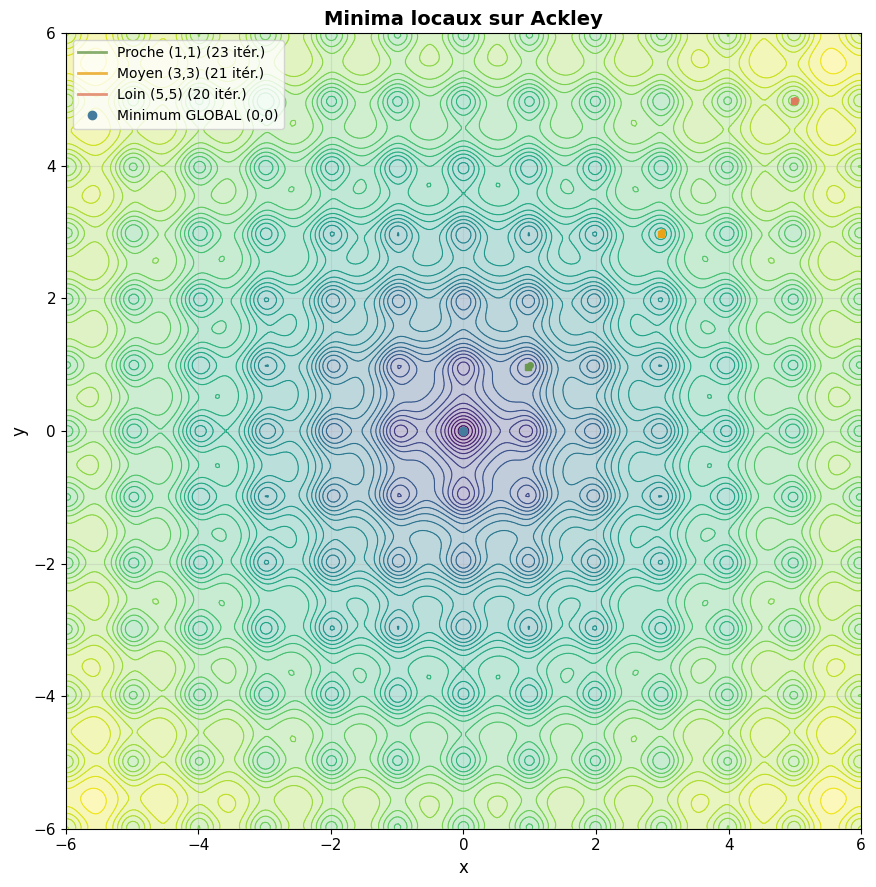

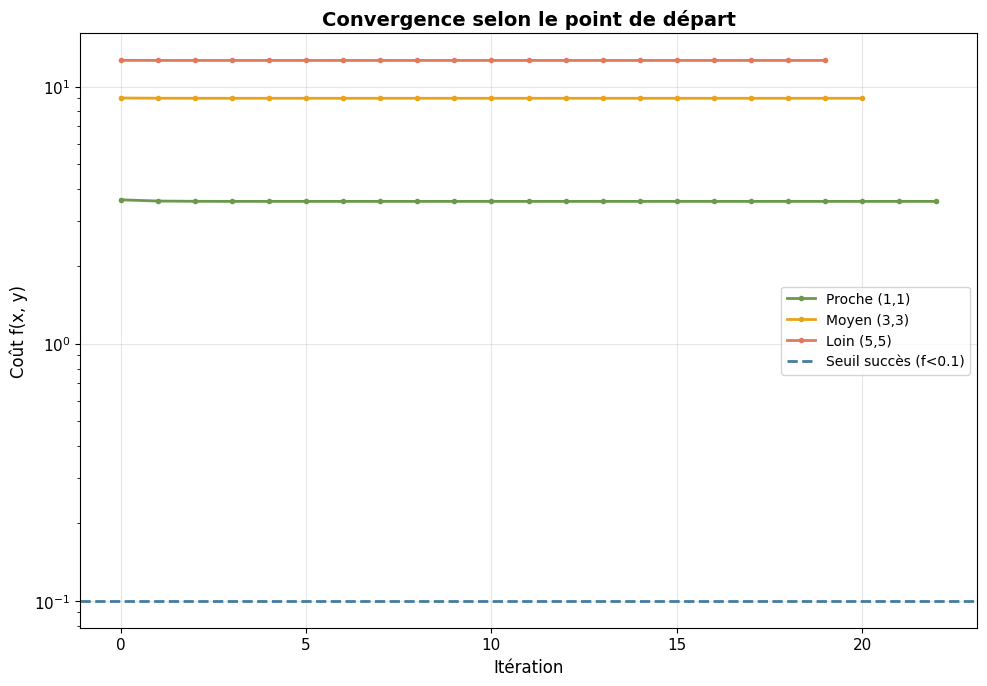

In [17]:
print("\n" + "-"*70)
print("CAS D'ÉCHEC 3 : Minimum Local (Piège d'Ackley)")
print("-"*70)

# Tester Ackley avec plusieurs points de départ
starting_points = [
    ("Proche (1,1)", np.array([1.0, 1.0])),
    ("Moyen (3,3)", np.array([3.0, 3.0])),
    ("Loin (5,5)", np.array([5.0, 5.0]))
]

trajectories_fail3 = {}
costs_fail3 = {}

for name, x0 in starting_points:
    traj, costs = gradient_descent(
        ackley, grad_ackley, x0,
        learning_rate=0.01, max_iter=500
    )
    trajectories_fail3[name] = traj
    costs_fail3[name] = costs
    
    # Diagnostic
    final_point = traj[-1]
    final_cost = costs[-1]
    distance_to_global = np.linalg.norm(final_point)
    
    print(f"{name} : départ {x0}")
    print(f"  Arrivée : ({final_point[0]:.4f}, {final_point[1]:.4f})")
    print(f"  Coût final : {final_cost:.6f}")
    print(f"  Distance à (0,0) : {distance_to_global:.4f}")
    
    if final_cost < 0.1:
        print(f"  [ok] SUCCÈS : A trouvé le minimum global")
    else:
        print(f"  [x] ÉCHEC : Bloqué dans un minimum local")
    print()

# Graphe de comparaison
fig, ax = plt.subplots(figsize=(12, 9))

x = np.linspace(-6, 6, 300)
y = np.linspace(-6, 6, 300)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = ackley(np.array([X[i, j], Y[i, j]]))

ax.contour(X, Y, Z, levels=50, cmap='viridis', linewidths=0.8)
ax.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.3)

colors = ['#6A994E', '#E9A319', '#E07A5F']
for (name, traj), color in zip(trajectories_fail3.items(), colors):
    ax.plot(traj[:, 0], traj[:, 1], 
           color=color, linewidth=2, alpha=0.8,
           label=f'{name} ({len(traj)} itér.)')
    
    # Début et fin
    ax.plot(traj[0, 0], traj[0, 1], 'o', color=color, markersize=4)
    ax.plot(traj[-1, 0], traj[-1, 1], 's', color=color, markersize=4)

# Marquer le minimum global
ax.plot(0.0, 0.0, 'o', color='#457B9D', markersize=6, label='Minimum GLOBAL (0,0)')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Minima locaux sur Ackley', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('../figures/temp/echec3_minima_locaux.png', dpi=300, bbox_inches='tight')
plt.show()


# Graphe de convergence
fig, ax = plt.subplots(figsize=(10, 7))

for (name, costs), color in zip(costs_fail3.items(), colors):
    ax.plot(costs, color=color, linewidth=2, label=name, marker='o', markersize=3)

# Ligne pour montrer le seuil de "succès"
ax.axhline(y=0.1, color='#457B9D', linestyle='--', linewidth=2, 
          label='Seuil succès (f<0.1)')

ax.set_xlabel('Itération', fontsize=12)
ax.set_ylabel('Coût f(x, y)', fontsize=12)
ax.set_title('Convergence selon le point de départ', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('../figures/temp/echec3_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 5.4 Momentum trop élevé : Oscillations


----------------------------------------------------------------------
CAS D'ÉCHEC 4 : Momentum trop élevé → Oscillations
----------------------------------------------------------------------
β=0.5 : 45 itérations, 5 oscillations
  Coût final : 1.03e-14
  [ok] Converge normalement

β=0.9 : 201 itérations, 42 oscillations
  Coût final : 4.16e-08
  [!]  Converge mais avec beaucoup d'oscillations

β=0.95 : 201 itérations, 41 oscillations
  Coût final : 9.16e-04
  [x] N'a pas convergé correctement

β=0.99 : 201 itérations, 41 oscillations
  Coût final : 8.26e+00
  [x] N'a pas convergé correctement



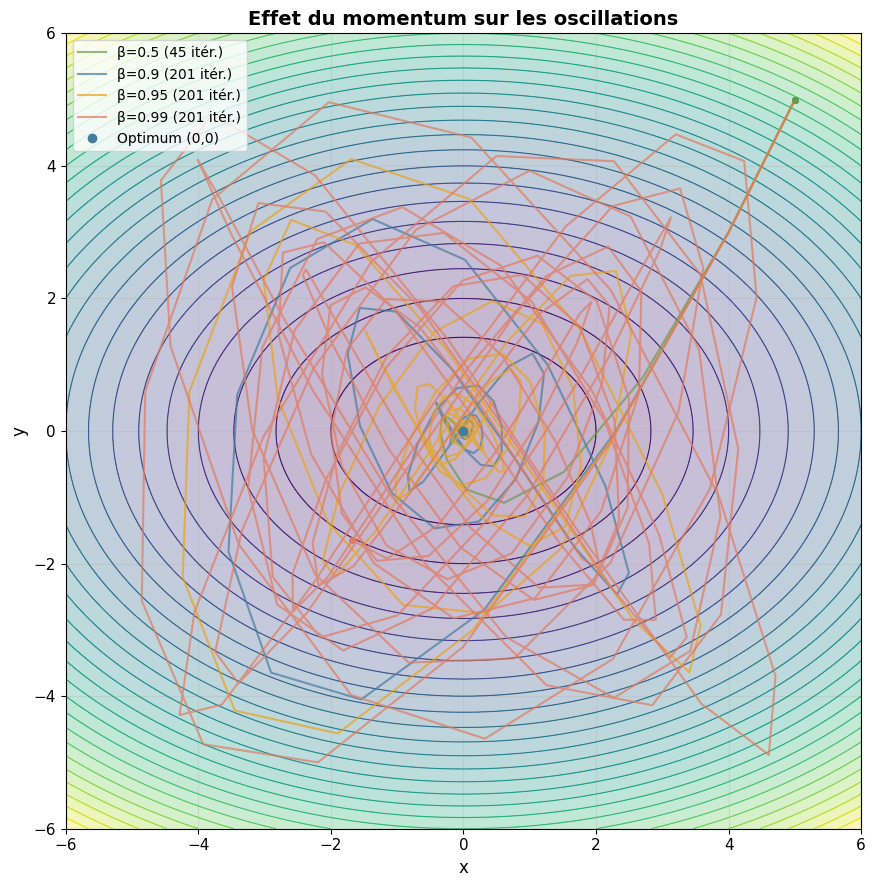

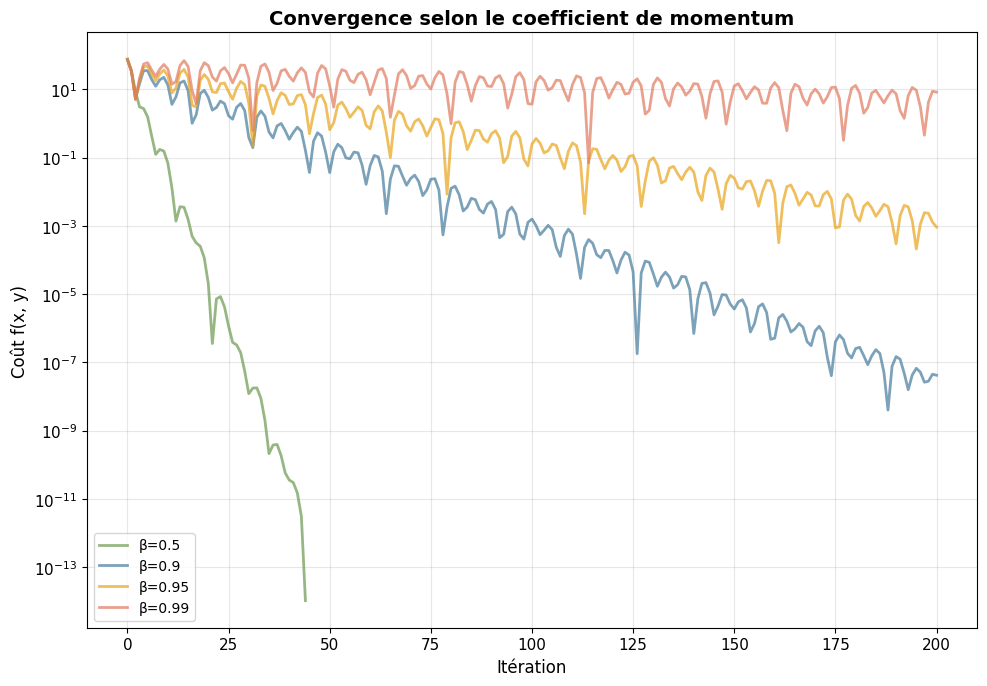

In [18]:
print("\n" + "-"*70)
print("CAS D'ÉCHEC 4 : Momentum trop élevé → Oscillations")
print("-"*70)

# Tester différents momentum sur quadratique
x0 = np.array([5.0, 5.0])
momentum_values = [0.5, 0.9, 0.95, 0.99]

trajectories_fail4 = {}
costs_fail4 = {}

for beta in momentum_values:
    traj, costs = gradient_descent_momentum(
        quadratique, grad_quadratique, x0,
        learning_rate=0.1, momentum=beta, max_iter=200
    )
    trajectories_fail4[f'β={beta}'] = traj
    costs_fail4[f'β={beta}'] = costs
    
    # Diagnostic
    final_cost = costs[-1]
    # Compter les oscillations (coût qui monte puis descend)
    oscillations = sum(1 for i in range(1, len(costs)-1) 
                      if costs[i] > costs[i-1] and costs[i] > costs[i+1])
    
    print(f"β={beta} : {len(traj)} itérations, {oscillations} oscillations")
    print(f"  Coût final : {final_cost:.2e}")
    
    if final_cost < 1e-6:
        if oscillations > 10:
            print(f"  [!]  Converge mais avec beaucoup d'oscillations")
        else:
            print(f"  [ok] Converge normalement")
    else:
        print(f"  [x] N'a pas convergé correctement")
    print()

# Graphe de comparaison
fig, ax = plt.subplots(figsize=(12, 9))

x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = quadratique(np.array([X[i, j], Y[i, j]]))

ax.contour(X, Y, Z, levels=30, cmap='viridis', linewidths=0.8)
ax.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.3)

colors = ['#6A994E', '#457B9D', '#E9A319', '#E07A5F']
for (name, traj), color in zip(trajectories_fail4.items(), colors):
    ax.plot(traj[:, 0], traj[:, 1], 
           color=color, linewidth=1.5, alpha=0.7,
           label=f'{name} ({len(traj)} itér.)')
    
    # Début
    ax.plot(traj[0, 0], traj[0, 1], 'o', color='#6A994E', markersize=4)
    
    # Dernier point
    ax.plot(traj[-1, 0], traj[-1, 1], 'o', color=color, markersize=4)

ax.plot(0, 0, 'o', color='#457B9D', markersize=6, label='Optimum (0,0)')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Effet du momentum sur les oscillations', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('../figures/temp/echec4_momentum_oscillations.png', dpi=300, bbox_inches='tight')
plt.show()


# Graphe de convergence
fig, ax = plt.subplots(figsize=(10, 7))

for (name, costs), color in zip(costs_fail4.items(), colors):
    ax.plot(costs, color=color, linewidth=2, label=name, alpha=0.7)

ax.set_xlabel('Itération', fontsize=12)
ax.set_ylabel('Coût f(x, y)', fontsize=12)
ax.set_title('Convergence selon le coefficient de momentum', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('../figures/temp/echec4_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## 5.5 Ravine étroite : Zigzags Extrêmes


----------------------------------------------------------------------
CAS D'ÉCHEC 5 : Ravine Étroite → Zigzags Extrêmes
----------------------------------------------------------------------
  Iter 0: grad_norm = 2.00e+03, cost = 10100.000000
  Iter 1: grad_norm = 2.00e+03, cost = 10096.040000
  Iter 2: grad_norm = 2.00e+03, cost = 10092.236816
  Iter 3: grad_norm = 2.00e+03, cost = 10088.584238
  Iter 4: grad_norm = 2.00e+03, cost = 10085.076302
  Iter 100: grad_norm = 2.00e+03, cost = 10001.758795
  Iter 200: grad_norm = 2.00e+03, cost = 10000.030934
Simple : 301 itérations
  Coût final : 1.00e+04

Momentum : 301 itérations
  Coût final : 1.48e-10


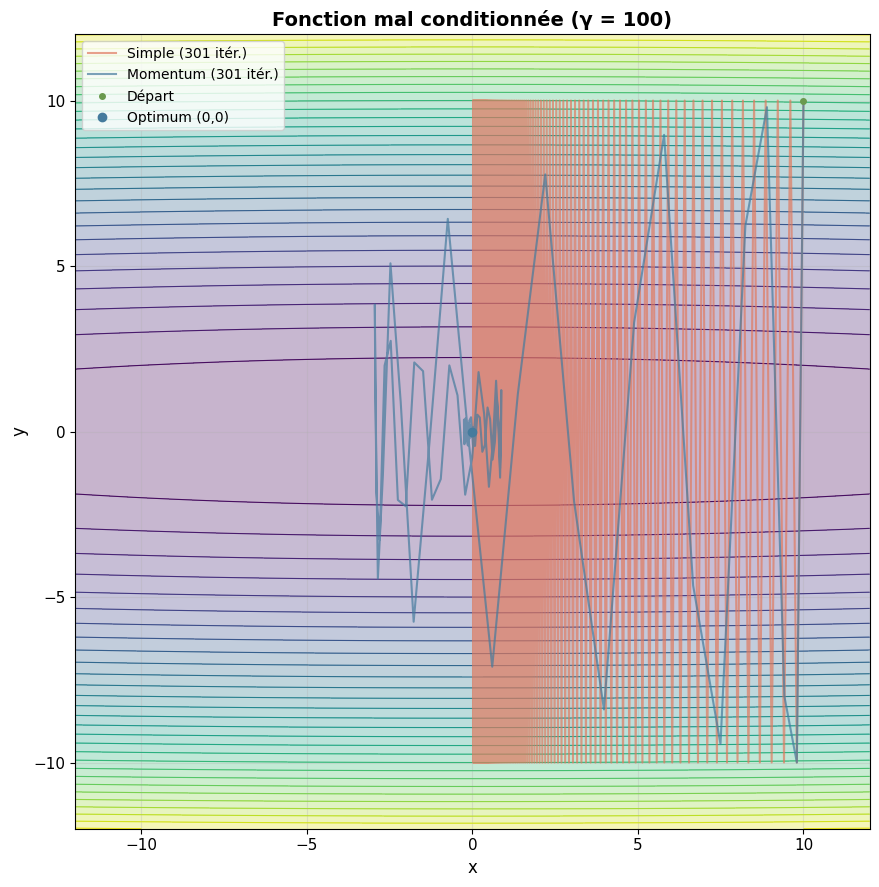

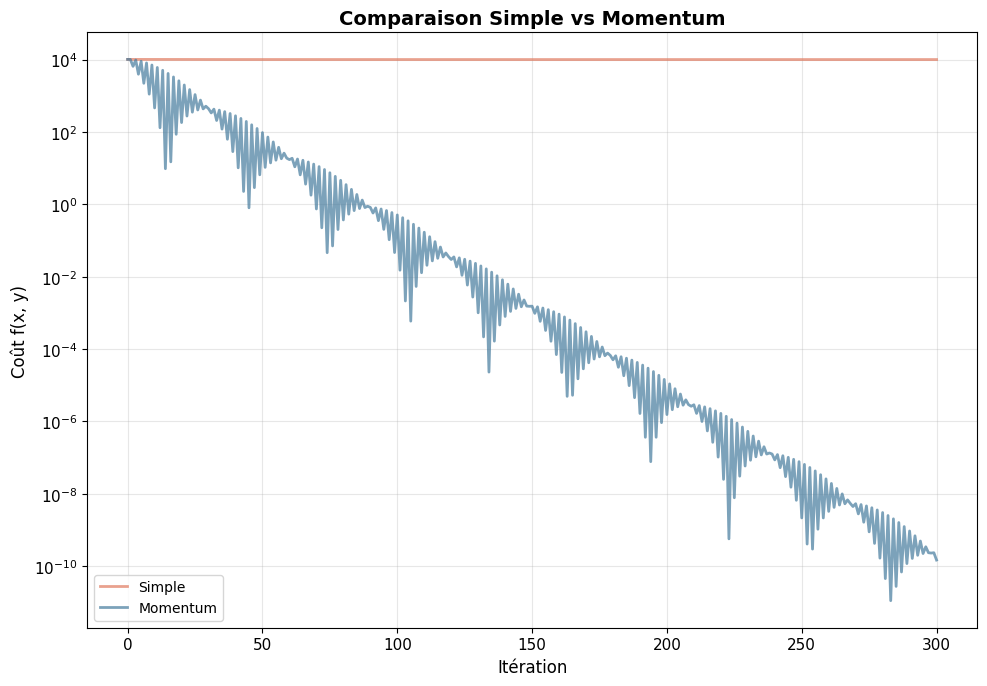

In [19]:
print("\n" + "-"*70)
print("CAS D'ÉCHEC 5 : Ravine Étroite → Zigzags Extrêmes")
print("-"*70)

# Fonction quadratique très mal conditionnée
def quadratique_extreme(x):
    """f(x,y) = x² + 100y² - ravine très étroite selon x"""
    return x[0]**2 + 100*x[1]**2

def grad_quadratique_extreme(x):
    return np.array([2*x[0], 200*x[1]])

x0 = np.array([10.0, 10.0])

# Comparer Simple vs Momentum
traj_simple_zig, costs_simple_zig = gradient_descent(
    quadratique_extreme, grad_quadratique_extreme, x0,
    learning_rate=0.01, max_iter=300
)

traj_momentum_zig, costs_momentum_zig = gradient_descent_momentum(
    quadratique_extreme, grad_quadratique_extreme, x0,
    learning_rate=0.01, momentum=0.9, max_iter=300
)

print(f"Simple : {len(traj_simple_zig)} itérations")
print(f"  Coût final : {costs_simple_zig[-1]:.2e}")

print(f"\nMomentum : {len(traj_momentum_zig)} itérations")
print(f"  Coût final : {costs_momentum_zig[-1]:.2e}")

# Graphe de comparaison
fig, ax = plt.subplots(figsize=(12, 9))

x = np.linspace(-12, 12, 200)
y = np.linspace(-12, 12, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = quadratique_extreme(np.array([X[i, j], Y[i, j]]))

ax.contour(X, Y, Z, levels=30, cmap='viridis', linewidths=0.8)
ax.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.3)

# Simple en rouge (zigzags)
ax.plot(traj_simple_zig[:, 0], traj_simple_zig[:, 1], 
       '-', color='#E07A5F', linewidth=1.5, alpha=0.7, label=f'Simple ({len(traj_simple_zig)} itér.)')

# Momentum en bleu (plus lisse)
ax.plot(traj_momentum_zig[:, 0], traj_momentum_zig[:, 1], 
       '-', color='#457B9D', linewidth=1.5, alpha=0.7, label=f'Momentum ({len(traj_momentum_zig)} itér.)')

# Points de départ et arrivée
ax.plot(10, 10, 'o', color='#6A994E', markersize=4, label='Départ')
ax.plot(0, 0, 'o', color='#457B9D', markersize=6, label='Optimum (0,0)')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Fonction mal conditionnée (γ = 100)', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('../figures/temp/echec5_zigzags_ravine.png', dpi=300, bbox_inches='tight')
plt.show()


# Graphe de convergence
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(costs_simple_zig, '-', color='#E07A5F', linewidth=2, label='Simple', alpha=0.7)
ax.plot(costs_momentum_zig, '-', color='#457B9D', linewidth=2, label='Momentum', alpha=0.7)

ax.set_xlabel('Itération', fontsize=12)
ax.set_ylabel('Coût f(x, y)', fontsize=12)
ax.set_title('Comparaison Simple vs Momentum', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig('../figures/temp/echec5_convergence.png', dpi=300, bbox_inches='tight')
plt.show()



## Tableau récapitulatif des échecs

In [20]:
print("\n" + "="*70)
print("TABLEAU RÉCAPITULATIF DES CAS D'ÉCHEC")
print("="*70)

import pandas as pd

data_echecs = {
    'Cas d\'Échec': [
        '1. LR trop grand',
        '2. LR trop petit',
        '3. Minimum local',
        '4. Momentum excessif',
        '5. Ravine étroite'
    ],
    'Symptôme': [
        'Divergence, explosion',
        'Stagnation, progression lente',
        'Converge mais pas au global',
        'Oscillations persistantes',
        'Zigzags inefficaces'
    ],
    'Cause': [
        'α > seuil stabilité',
        'α << gradient',
        'Point initial éloigné',
        'β proche de 1.0',
        'Fonction mal conditionnée'
    ],
    'Solution': [
        'Réduire α ou use Adam',
        'Augmenter α prudemment',
        'Momentum/Adam ou restart',
        'Réduire β (0.9 typique)',
        'Momentum ou Adam'
    ],
    'Graphe': [
        'echec1_lr_divergence.png',
        'echec2_lr_stagnation.png',
        'echec3_minima_locaux.png',
        'echec4_momentum_oscillations.png',
        'echec5_zigzags_ravine.png'
    ]
}

df_echecs = pd.DataFrame(data_echecs)
print(df_echecs.to_string(index=False))

print("\n" + "="*70)
print("TOTAL : 10 graphes d'échecs générés (2 par cas)")
print("="*70)


TABLEAU RÉCAPITULATIF DES CAS D'ÉCHEC
         Cas d'Échec                      Symptôme                     Cause                 Solution                           Graphe
    1. LR trop grand         Divergence, explosion       α > seuil stabilité    Réduire α ou use Adam         echec1_lr_divergence.png
    2. LR trop petit Stagnation, progression lente             α << gradient   Augmenter α prudemment         echec2_lr_stagnation.png
    3. Minimum local   Converge mais pas au global     Point initial éloigné Momentum/Adam ou restart         echec3_minima_locaux.png
4. Momentum excessif     Oscillations persistantes           β proche de 1.0  Réduire β (0.9 typique) echec4_momentum_oscillations.png
   5. Ravine étroite           Zigzags inefficaces Fonction mal conditionnée         Momentum ou Adam        echec5_zigzags_ravine.png

TOTAL : 10 graphes d'échecs générés (2 par cas)


# 6. Notes pour le rapport

In [21]:
print("\n" + "="*70)
print("OBSERVATIONS POUR LE RAPPORT")
print("="*70)

print("""
1. FONCTION QUADRATIQUE
   - Tous les algorithmes convergent
   - Simple : zigzags visibles dus à la différence de courbure
   - Momentum/Nesterov : trajectoires plus lisses
   - Adam : convergence la plus rapide

2. ROSENBROCK
   - Fonction très difficile (vallée étroite)
   - Simple/Momentum/Nesterov : très lents
   - Adam : beaucoup plus efficace grâce à l'adaptation du learning rate

3. BOOTH
   - Convergence rapide pour tous les algorithmes
   - Paysage relativement simple

4. BEALE
   - Fonction avec de forts gradients près de l'origine
   - Nécessite un learning rate plus petit
   - Adam s'adapte automatiquement

5. HIMMELBLAU
   - 4 minima globaux équivalents
   - Le choix du point de départ détermine quel minimum est atteint
   - Tous les algorithmes convergent vers un des minima

CONCLUSION :
- Simple : fonctionne mais lent et zigzague
- Momentum : améliore Simple mais sensible aux paramètres
- Nesterov : légèrement meilleur que Momentum
- Adam : le plus robuste, s'adapte automatiquement
""")


OBSERVATIONS POUR LE RAPPORT

1. FONCTION QUADRATIQUE
   - Tous les algorithmes convergent
   - Simple : zigzags visibles dus à la différence de courbure
   - Momentum/Nesterov : trajectoires plus lisses
   - Adam : convergence la plus rapide

2. ROSENBROCK
   - Fonction très difficile (vallée étroite)
   - Simple/Momentum/Nesterov : très lents
   - Adam : beaucoup plus efficace grâce à l'adaptation du learning rate

3. BOOTH
   - Convergence rapide pour tous les algorithmes
   - Paysage relativement simple

4. BEALE
   - Fonction avec de forts gradients près de l'origine
   - Nécessite un learning rate plus petit
   - Adam s'adapte automatiquement

5. HIMMELBLAU
   - 4 minima globaux équivalents
   - Le choix du point de départ détermine quel minimum est atteint
   - Tous les algorithmes convergent vers un des minima

CONCLUSION :
- Simple : fonctionne mais lent et zigzague
- Momentum : améliore Simple mais sensible aux paramètres
- Nesterov : légèrement meilleur que Momentum
- Adam 